# Classiciation Model to Predict Whether Someone Has Blood Pressure

This worksheet is used for modeling data from the National Health & Nutrition Examination Survey between the years 2007 - 2016 with the intent of predicting whether someone between the ages of 18 - 80 has high blood pressure.</br>

Target Variable: **High Blood Pressure** (binary, yes or no)</br>

### TABLE OF CONTENTS
1. [Features](#FEATURES)
2. [Exploratory Data Analysis (EDA)](#EXPLORATORY-DATA-ANALYSIS)
3. [Modeling](#MODELING)
    - [Logistic Rergression - version 1](#Logistic-Regression-Model-v1) (two features)
    - [Logistic Rergression - version 2](#Logistic-Regression-Model-v2) (5 features)
    - [Logistic Regression w/Oversampling](#Logistic-Regression-With-Oversampling-Model) (5 features)
    - [Decision Tree](#Decision-Tree-Model)
    - [Random Forest](#Random-Forest-Model)
4. [Comparison of models](#COMPARISON-OF-MODELS)
5. Final selection results

-
### FEATURES 

Features that are under consideration for this model are:
1. BMI
2. Waist Circumference
3. Height
4. Weight
5. Gender
6. Age
7. Race
8. Frequency of eating out
9. Frequency of eating ready-to-eat meals
10. Frequencey of eating frozen foods
11. Whether smoked cigarettes 100 times in lifetime
12. Current frequency of smoking cigarettes
13. Whether have vigorous activity at work (over 10 min avg daily)
14. Whether have moderate activity at work (over 10 min avg daily)
15. Whether bike or walk to get to and from places 10 min continously each week
16. Whether do vigorous activity for recreational activity
17. Length of time spent sitting (avg daily)
18. Whether have had more than 12 alcoholic drinks in past year
19. Number of drinks had per day on average for past year
20. Occupation status
21. If have job, number of hours worked in past week

In [414]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report


from yellowbrick.model_selection import FeatureImportances

from mlxtend.plotting import plot_decision_regions

from collections import Counter

Populating the interactive namespace from numpy and matplotlib


-</br>
-</br>
### EXPLORATORY DATA ANALYSIS

-
#### Pull in cleaned dataset & create dummies
Un-pickle cleaned dataset for NHANES data (created in `data/NHANES_data_collection.ipynb`) to build model for predicting whether someone has high blood pressure (target variable) >

In [39]:
with open('data/pickles/nhanes_clean.pickle','rb') as read_file:
    nhanes_clean = pickle.load(read_file)

In [40]:
# create dummies for two oject columns: race & job status

nhanes_clean = pd.get_dummies(nhanes_clean)

In [41]:
len(nhanes_clean.columns)

29

-</br>
#### Split the data into Training, Validation, and Test Sets

In [42]:
X = nhanes_clean.drop(columns='High_Blood_Pressure')
y = nhanes_clean['High_Blood_Pressure']

In [270]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [271]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=.25,
                                                  random_state=42,
                                                  stratify = y_train_val
                                                 )

-</br>
#### Find the baseline high blood pressure probability
To find a 'baseline' we look at the probability of the 0/1 target for high blood pressure (1 = high blood pressure, 0 = not high blood pressure) for the y_train data.

0    0.649685
1    0.350315
Name: High_Blood_Pressure, dtype: float64


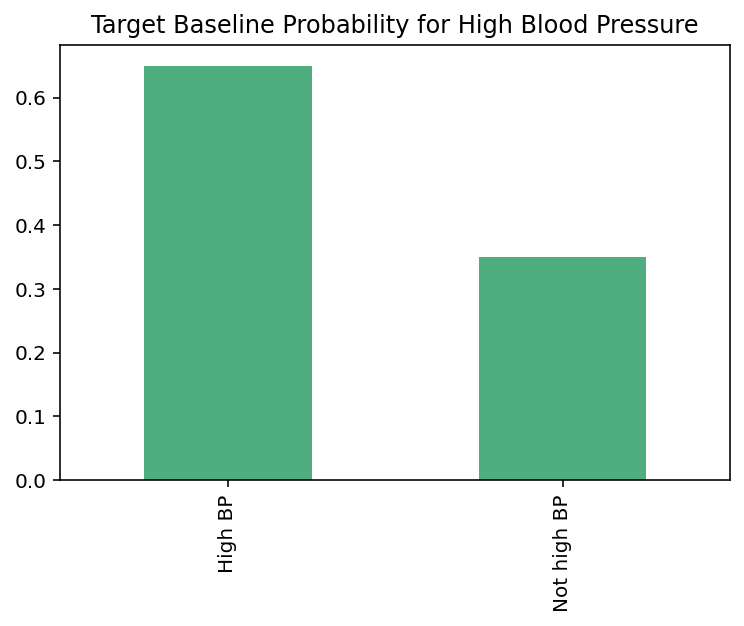

In [272]:
target_train_pcts = y_train.value_counts(normalize=True)
print(target_train_pcts)

xlabels = ['High BP', 'Not high BP']
target_train_pcts.plot(kind='bar', color='#50ad80')
plt.title('Target Baseline Probability for High Blood Pressure')
plt.xticks([0,1],xlabels);

-
#### Examine each variable's relationship to the target

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


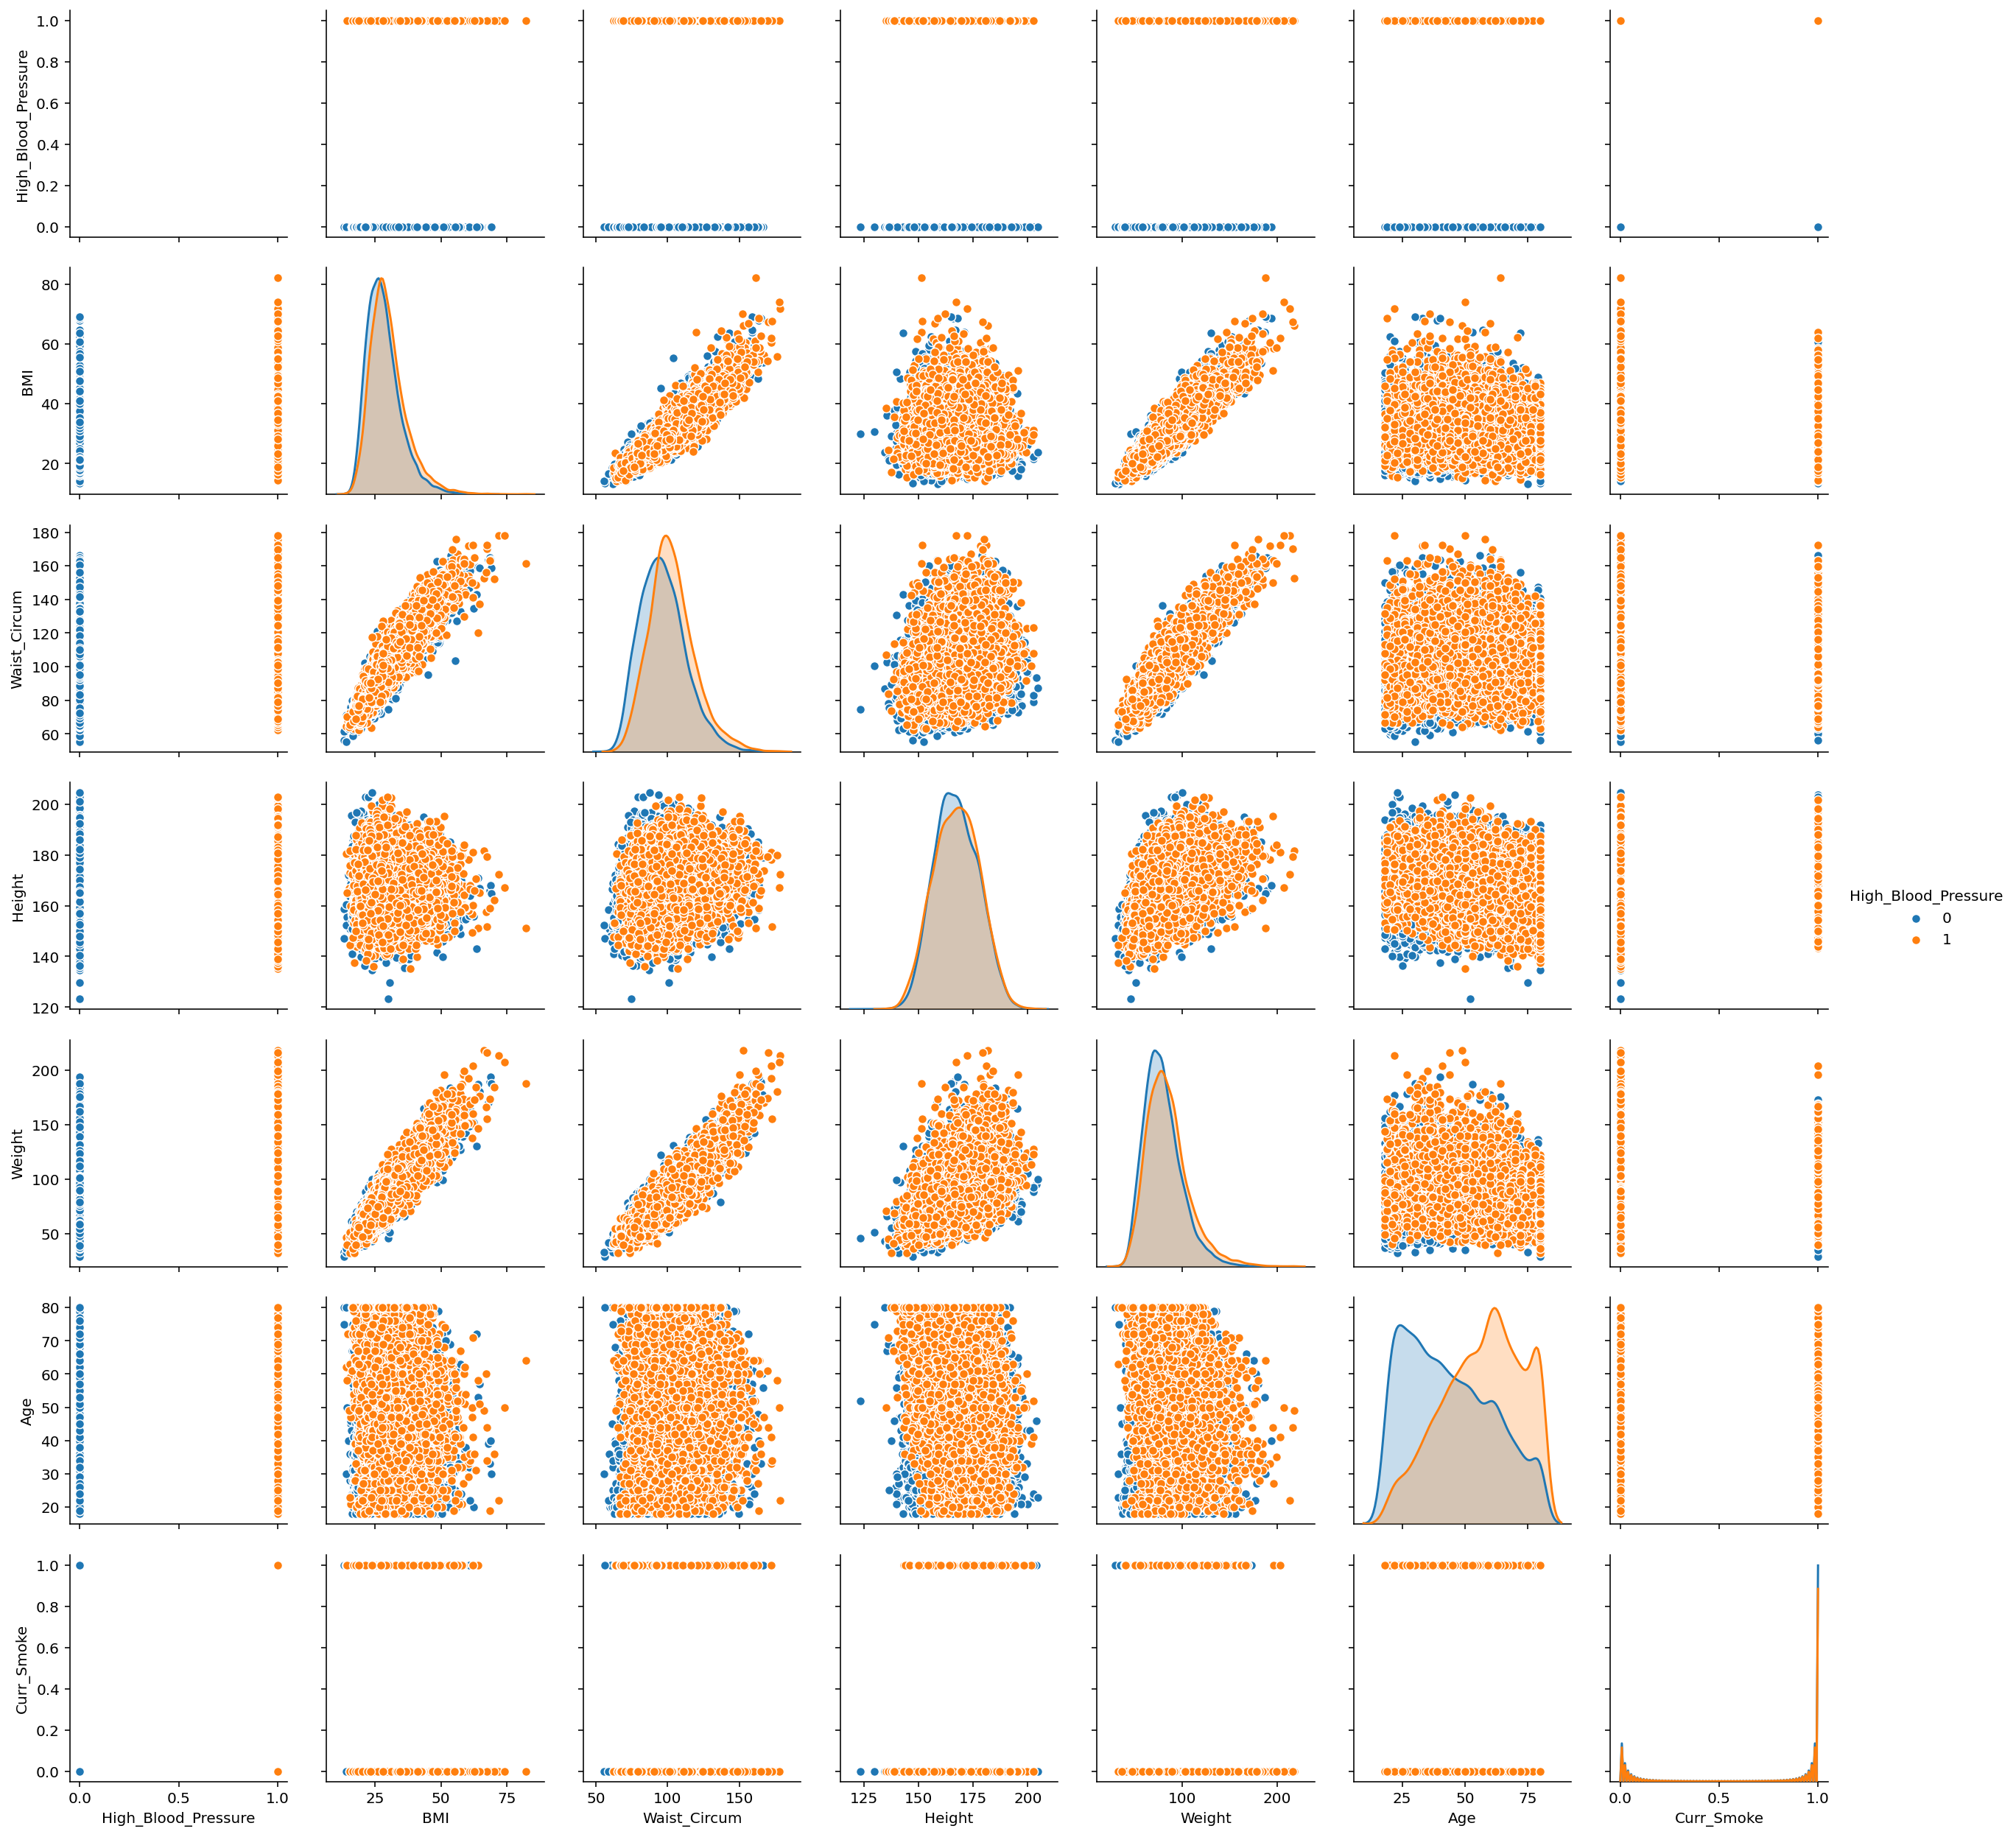

In [273]:
sns.pairplot(nhanes_clean[['High_Blood_Pressure','BMI','Waist_Circum',
                           'Height','Weight','Age','Curr_Smoke']], 
             hue='High_Blood_Pressure');

#### Takeaways:
- **AGE**: Looks like higher age is associated with higher likelihood of a positive target (higher blood pressure) 
- **WAIST CIRCUMFERENCE**: Looks as though higher waist circumference size has slight indication of higher blood pressure
- Remaining features are not that prominent

Take a closer look at the probability in buckets for features we think have relationship with high blood pressure >

In [274]:
def get_emp_prob(target='High_Blood_Pressure', column='Age', min_value=18, max_value=30):
    mask = (min_value <= nhanes_train[column]) & (nhanes_train[column] < max_value)
    return nhanes_train[mask][target].mean()

print(get_emp_prob())
print(get_emp_prob(min_value=30, max_value=50))
print(get_emp_prob(min_value=50, max_value=70))
print(get_emp_prob(min_value=70, max_value=90))

0.10563174788444704
0.27465143625062993
0.46336464560204954
0.5739257101238164


In [275]:
def get_emp_prob(target='High_Blood_Pressure', column='Waist_Circum', min_value=60, max_value=80):
    mask = (min_value <= nhanes_train[column]) & (nhanes_train[column] < max_value)
    return nhanes_train[mask][target].mean()

print(get_emp_prob())
print(get_emp_prob(min_value=80, max_value=100))
print(get_emp_prob(min_value=100, max_value=120))

0.17874632713026445
0.31313767477012217
0.41528455284552845


Indeed does indicate that Age and Waist Circumference has a relationship with blood pressure.  As each feature increases in size, so does the probability that the person will have high blood pressure


Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


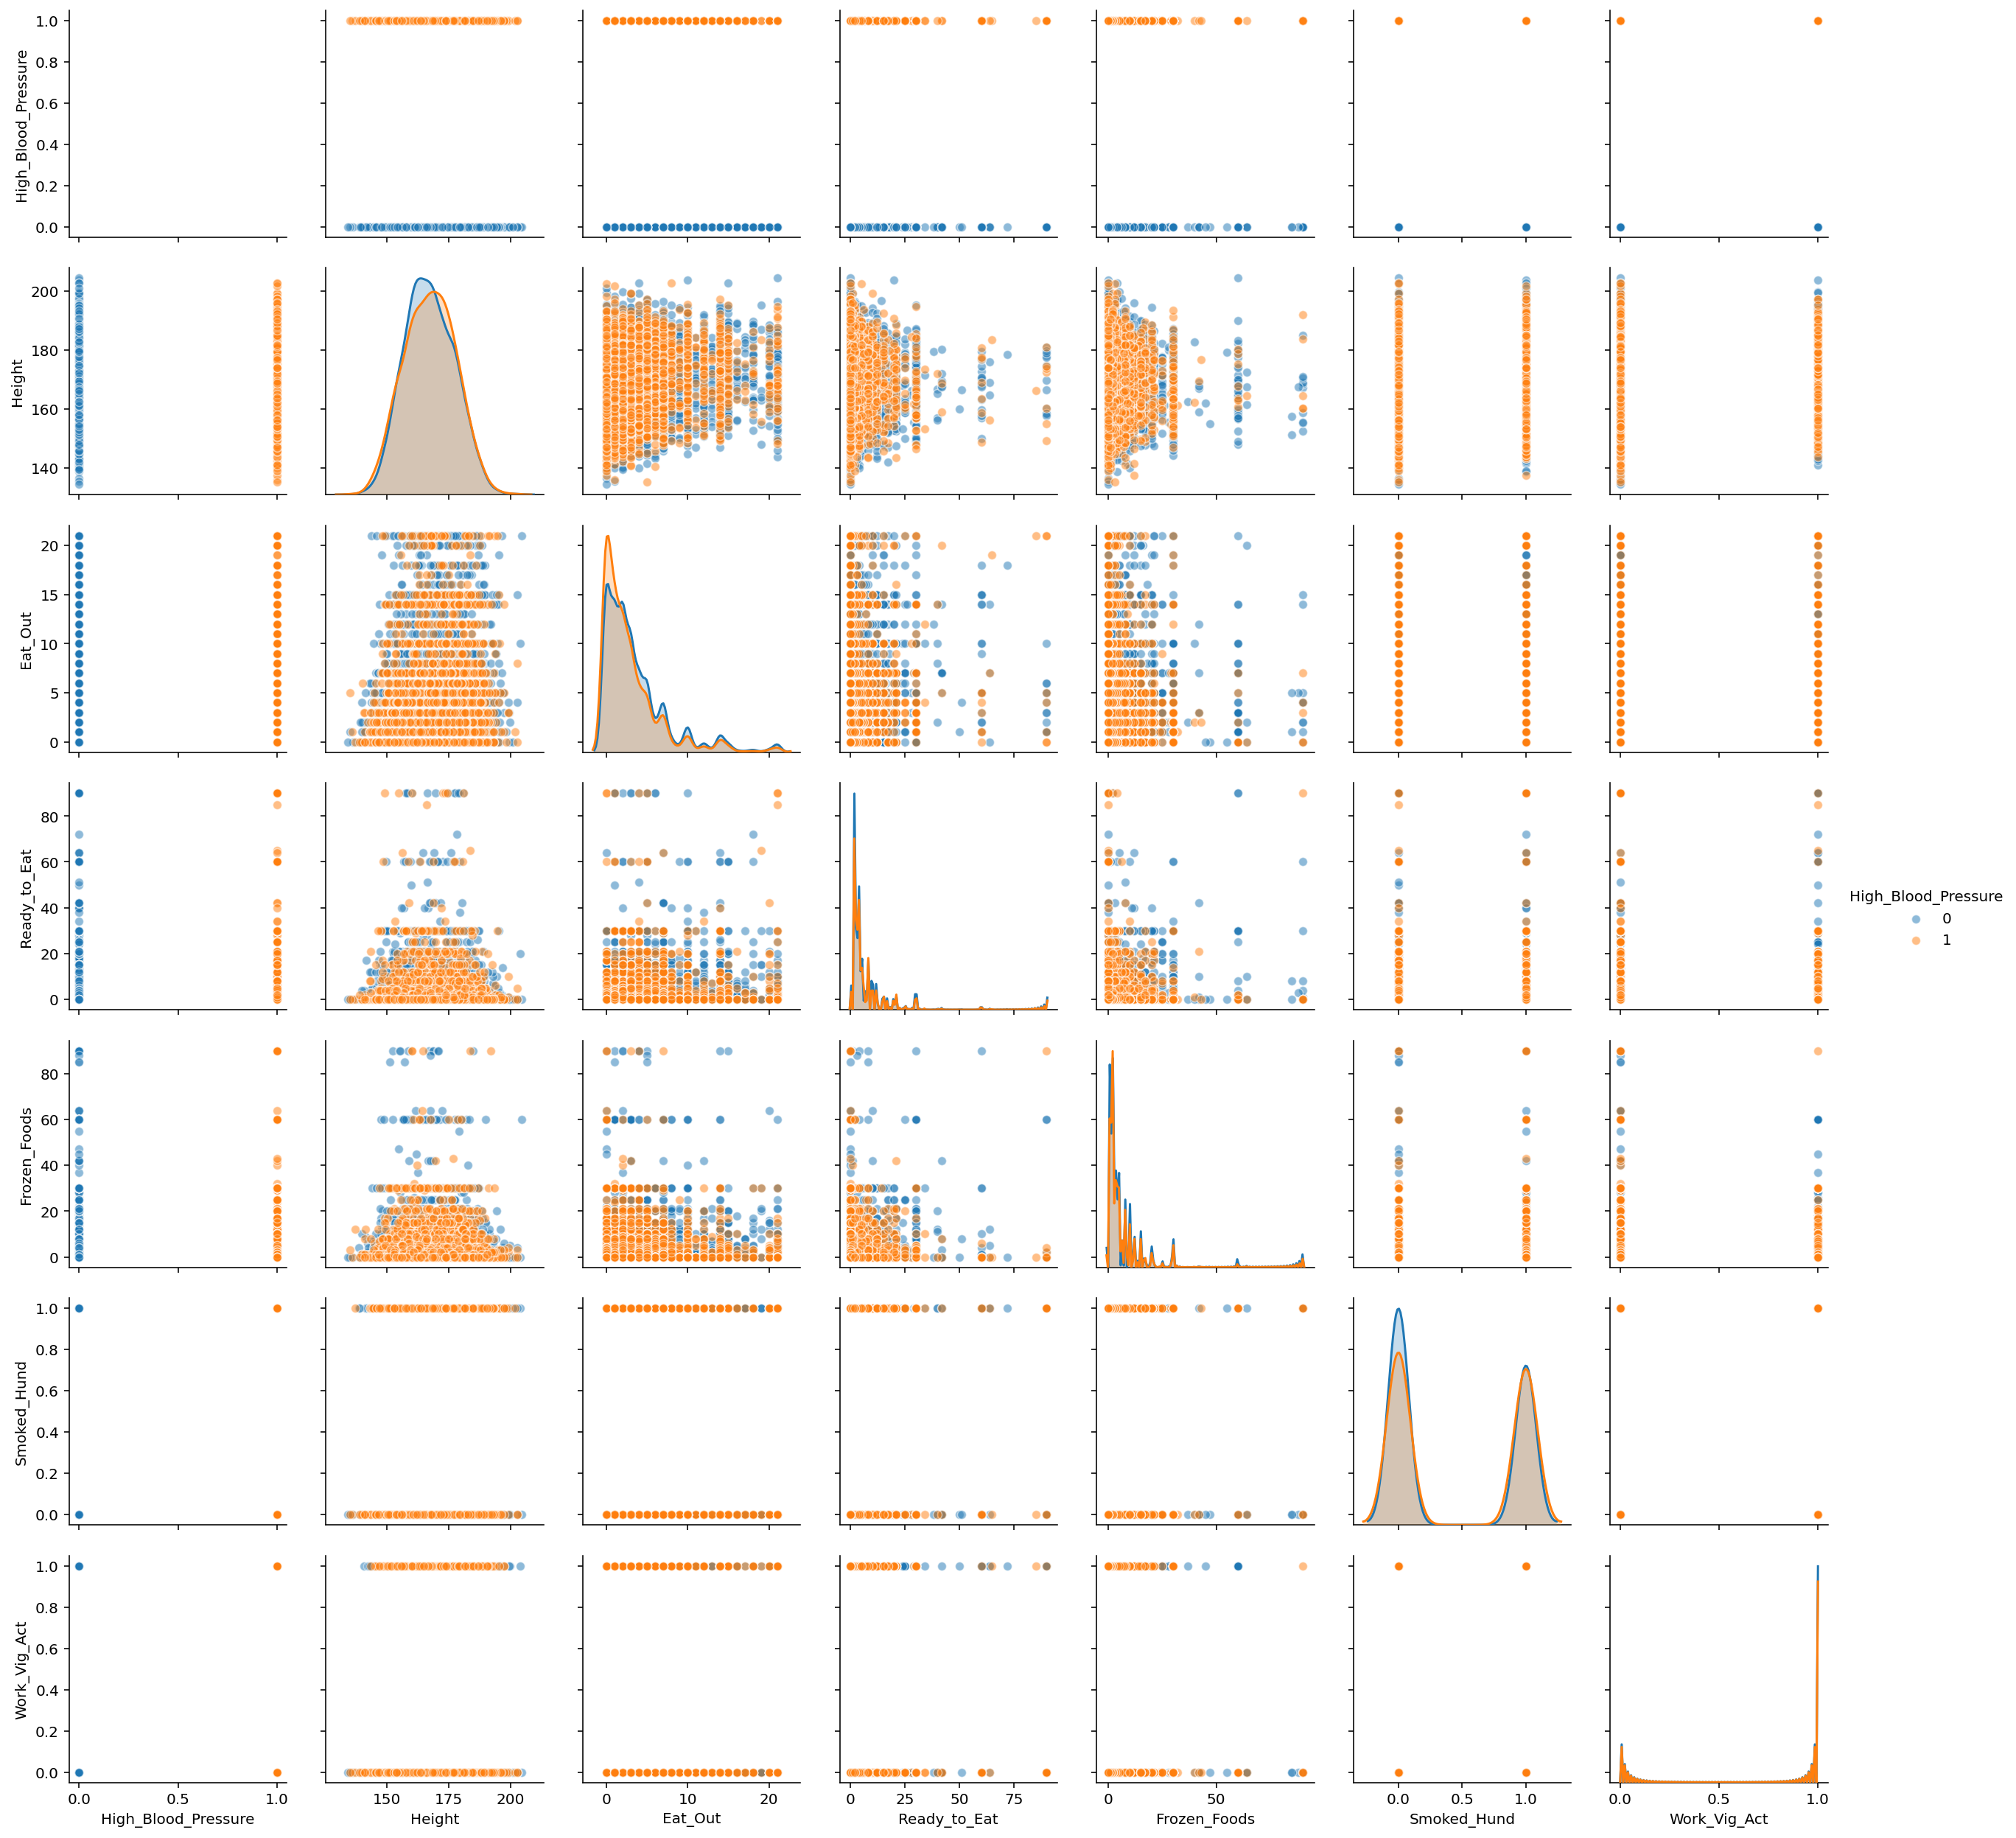

In [276]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Height','Eat_Out',
                           'Ready_to_Eat','Frozen_Foods','Smoked_Hund',
                           'Work_Vig_Act']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Smoked Hundred Cigarettes in Lifetime**: Seems there is a connection with not having smoked more than 100 cigarettes in lifetime and not having high blood pressure

Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


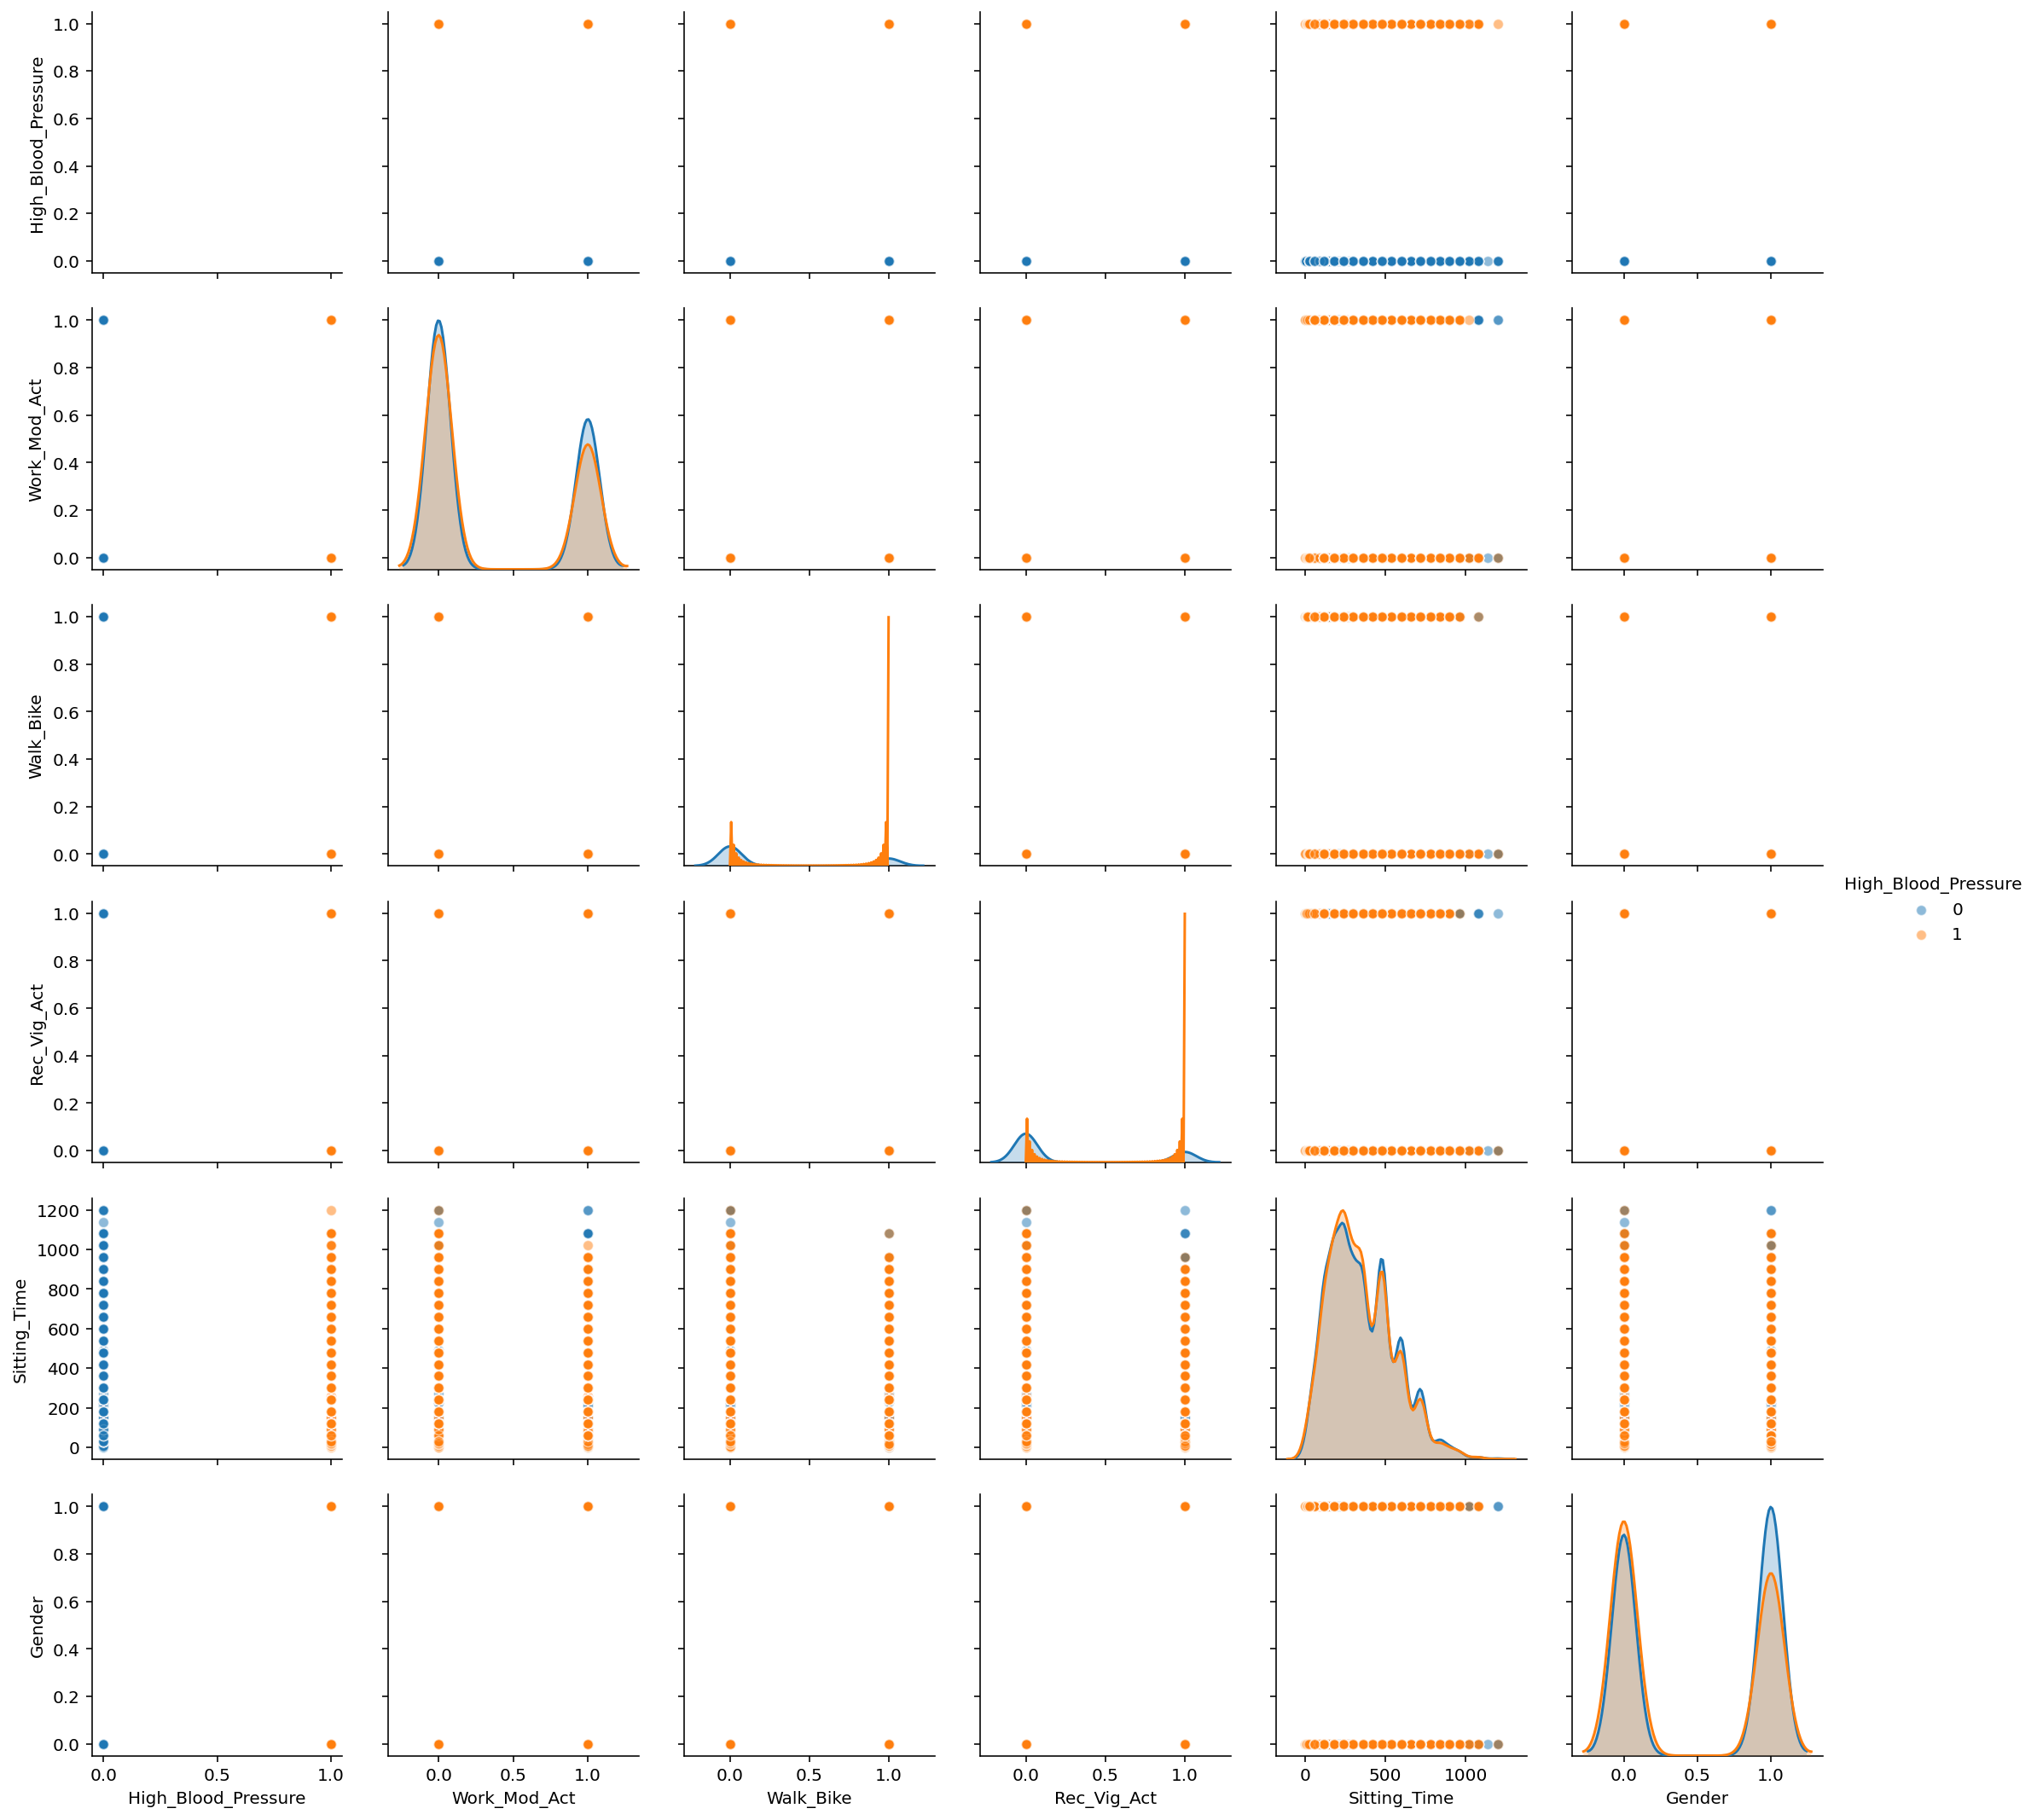

In [49]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Work_Mod_Act','Walk_Bike',
                           'Rec_Vig_Act','Sitting_Time','Gender']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Sitting Time**: There looks like a potential slight connection to higher sitting time and then higher chance of high blood pressure
- **Walk & Biking**: May also be relationship between this and not having high blood pressure
- **Vigorous Recreational Activity**: May also be relationship between this and not having high blood pressure


Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


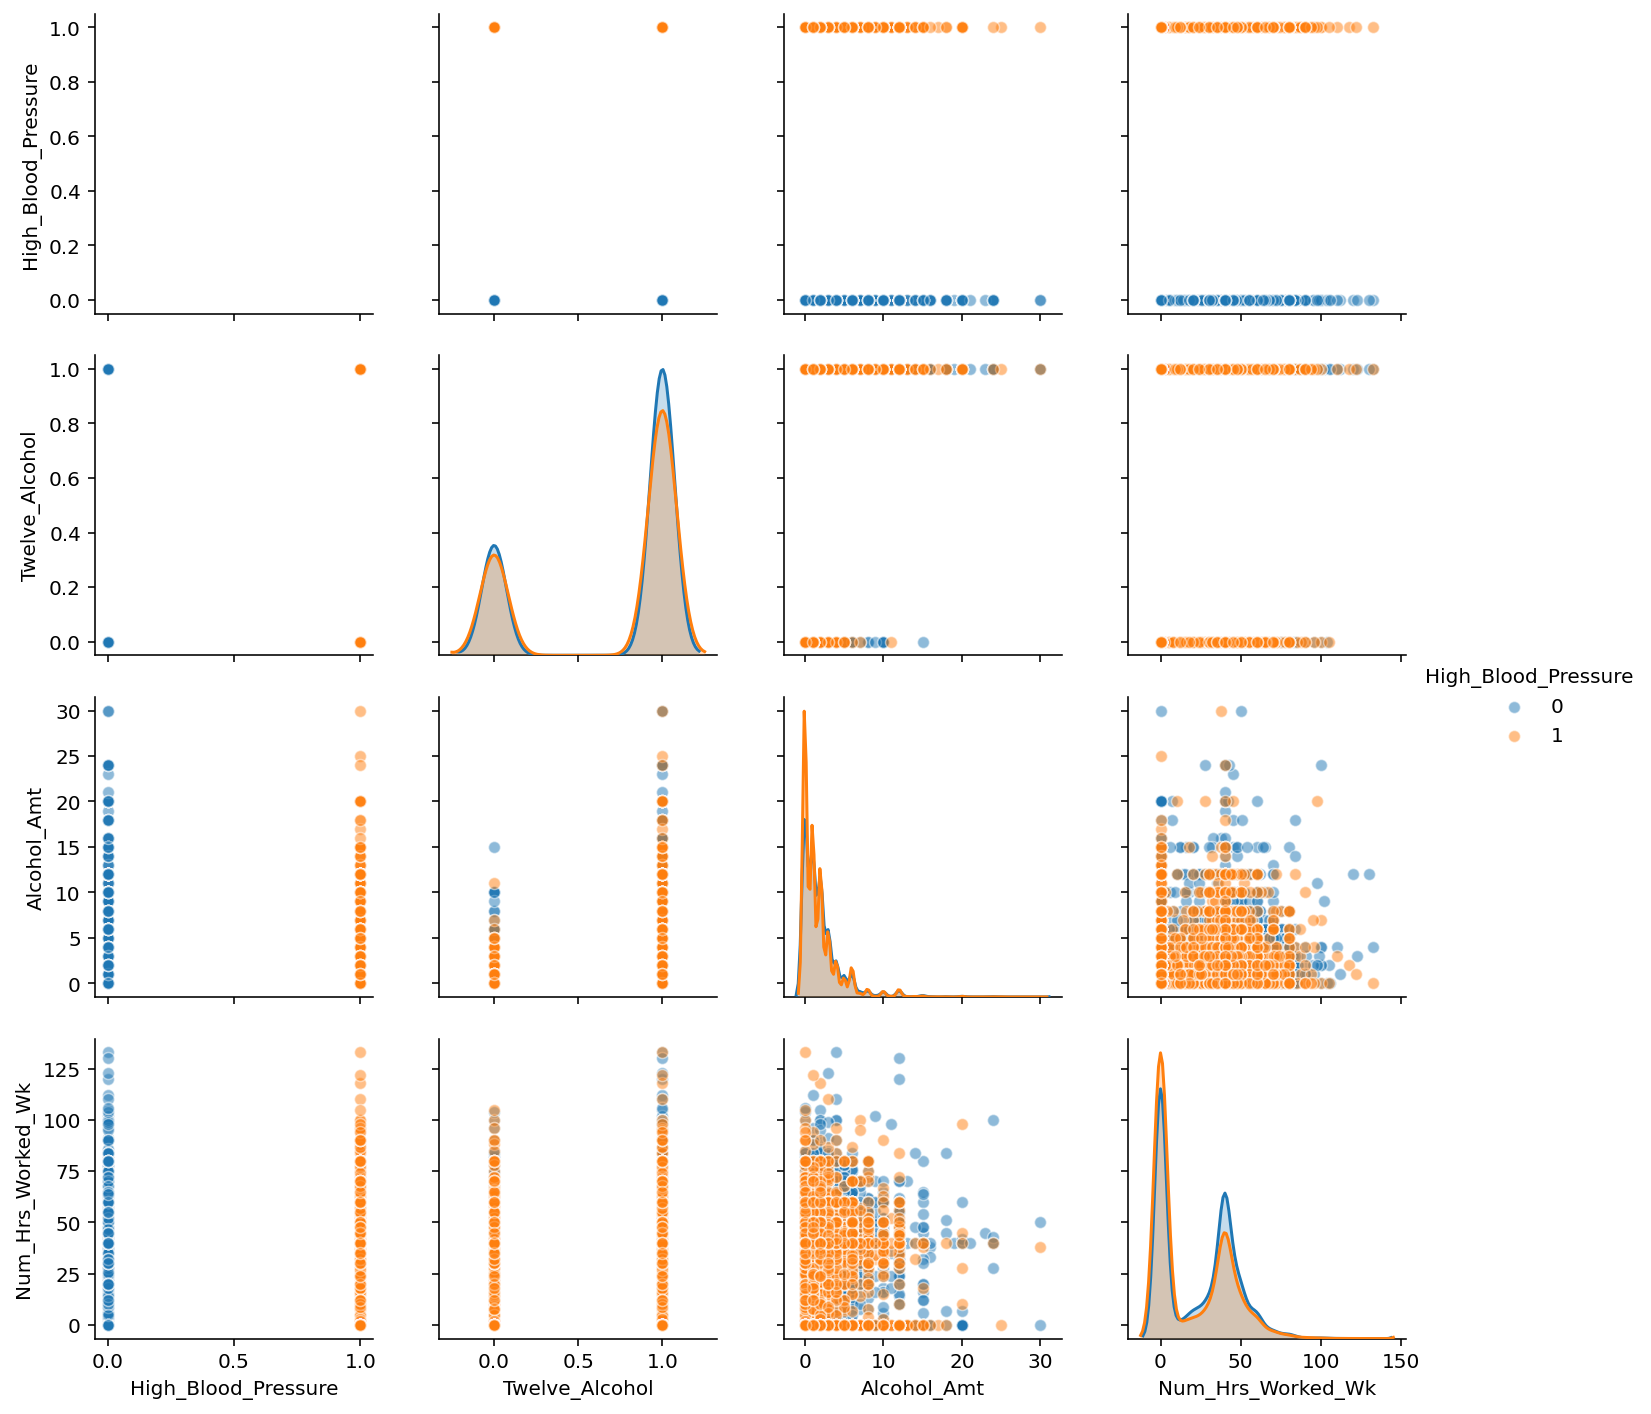

In [14]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Twelve_Alcohol',
                           'Alcohol_Amt','Num_Hrs_Worked_Wk']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Alcohol Amount**: Hard to tell clearly from graph, but seems there is a potential relationship between drinking more alcohol and having high blood pressure

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


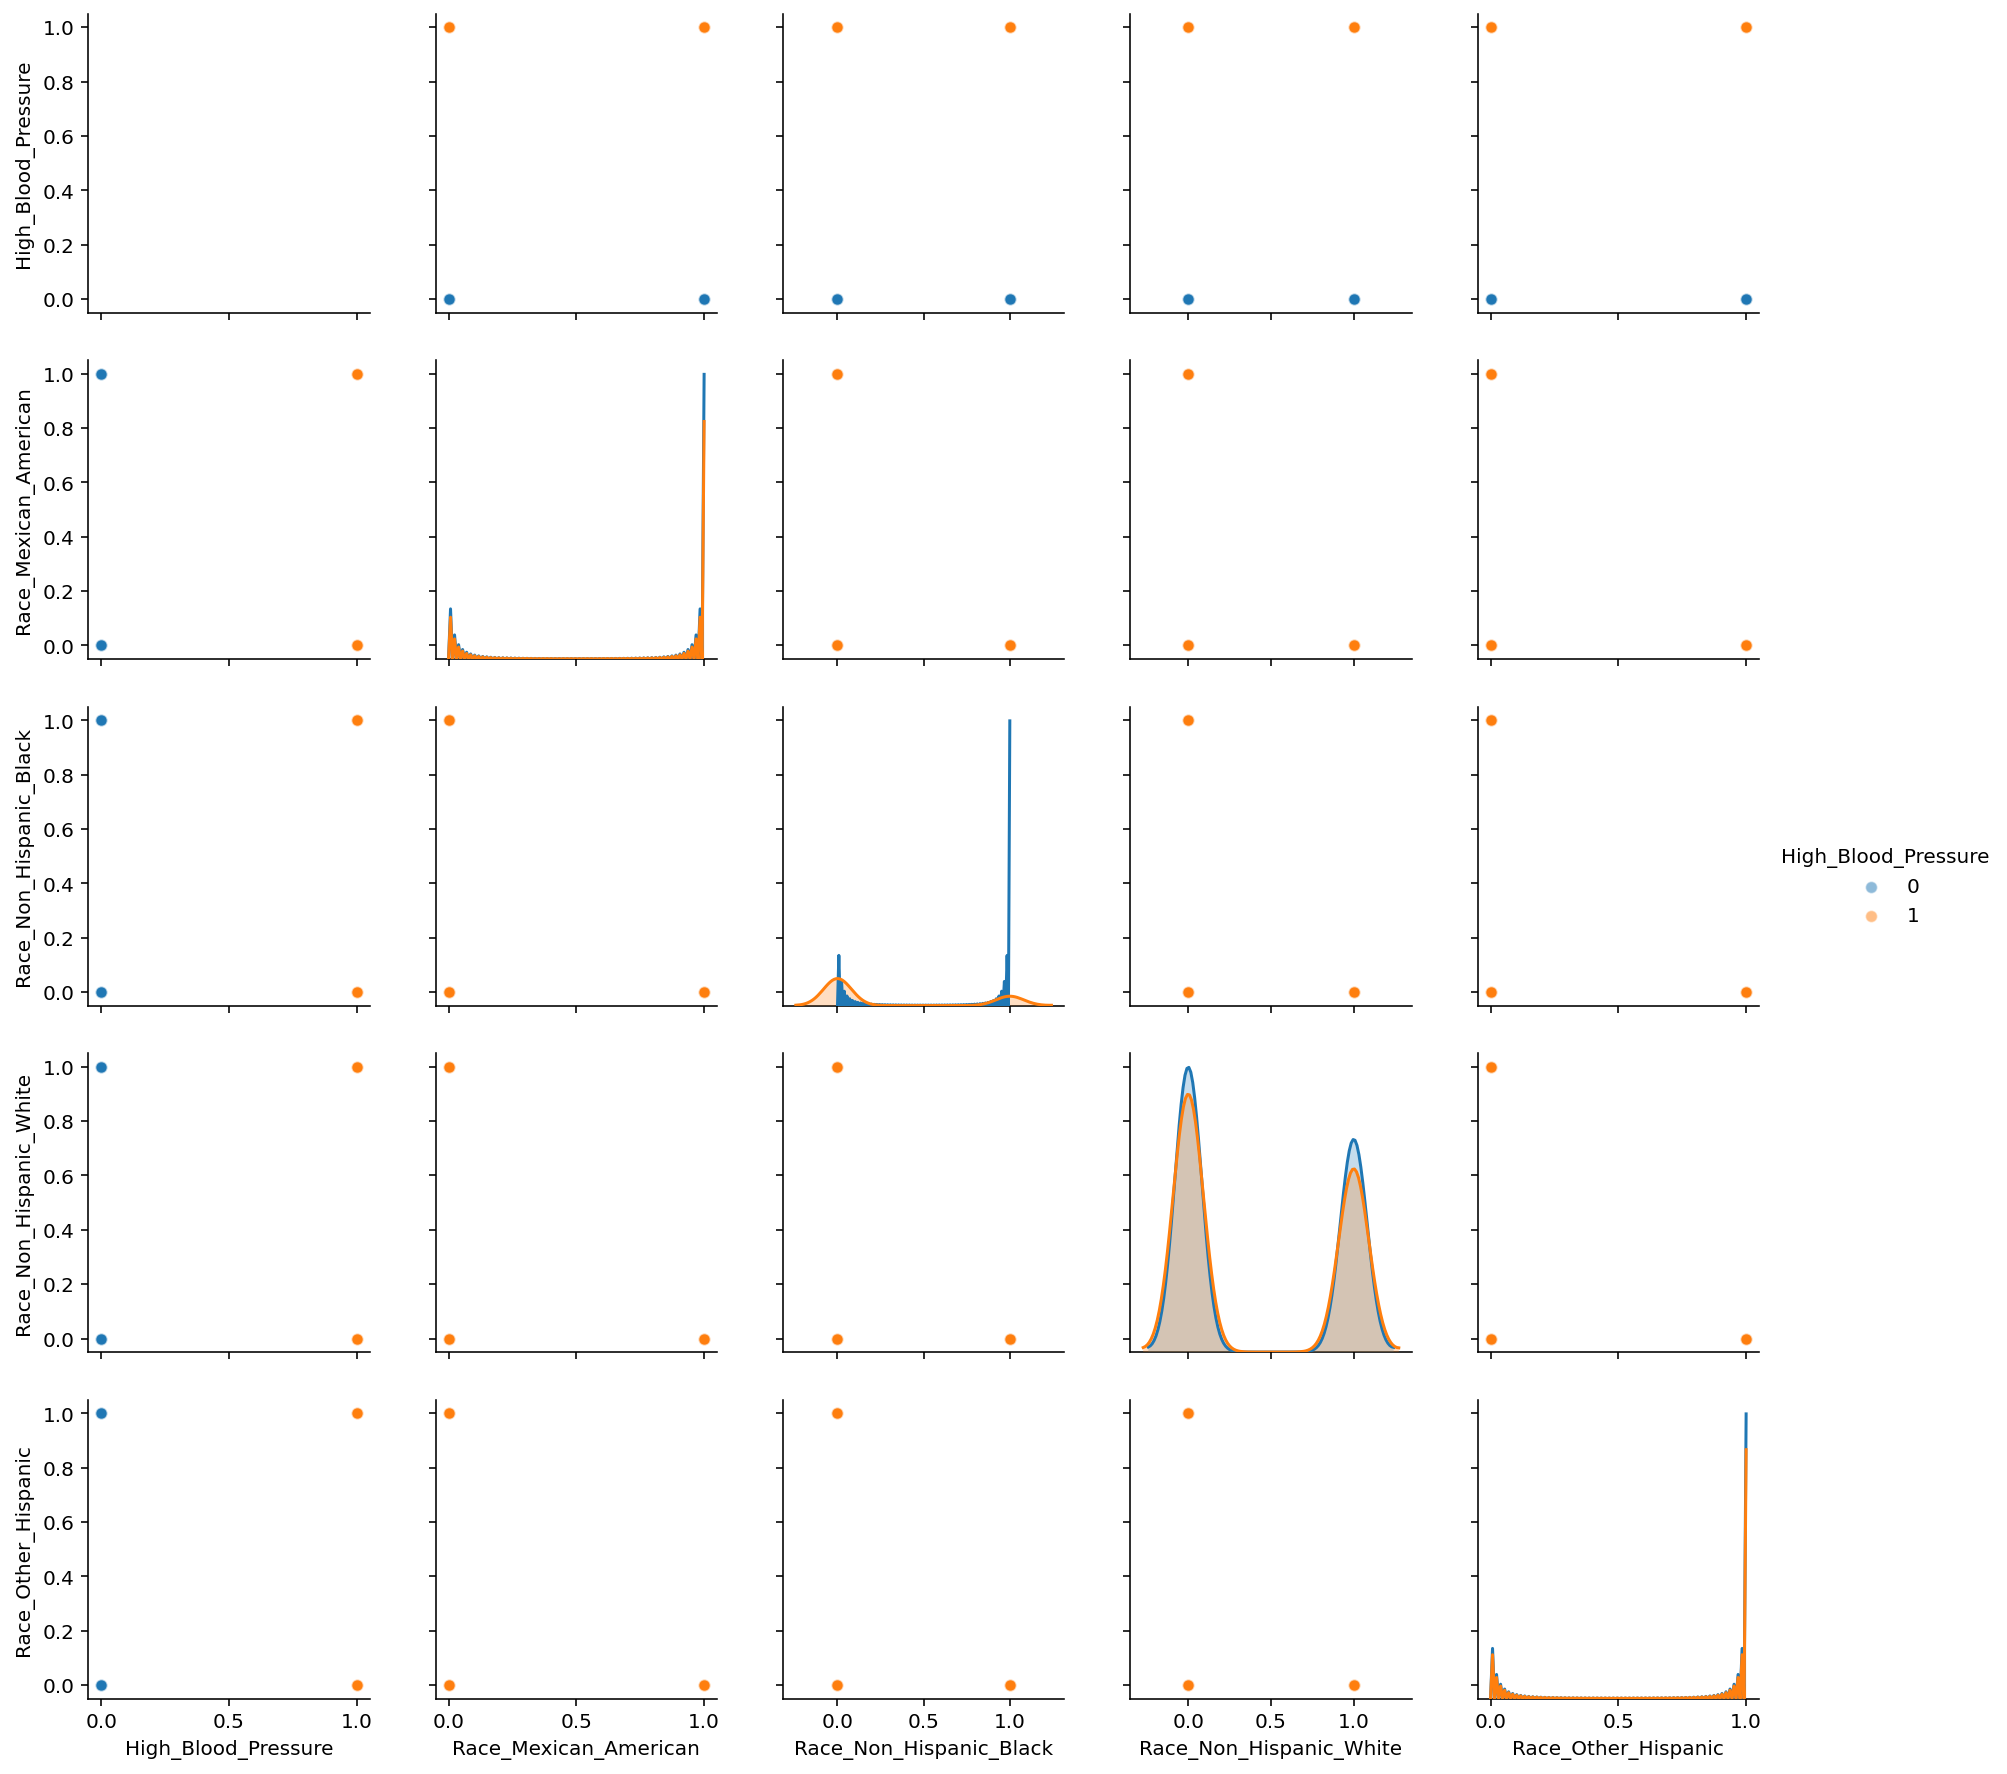

In [15]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Race_Mexican_American',
                           'Race_Non_Hispanic_Black',
                           'Race_Non_Hispanic_White','Race_Other_Hispanic'
                          ]],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Race - Black**: Looks like there may be a relationship between identifying as Black and having high blood pressure

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


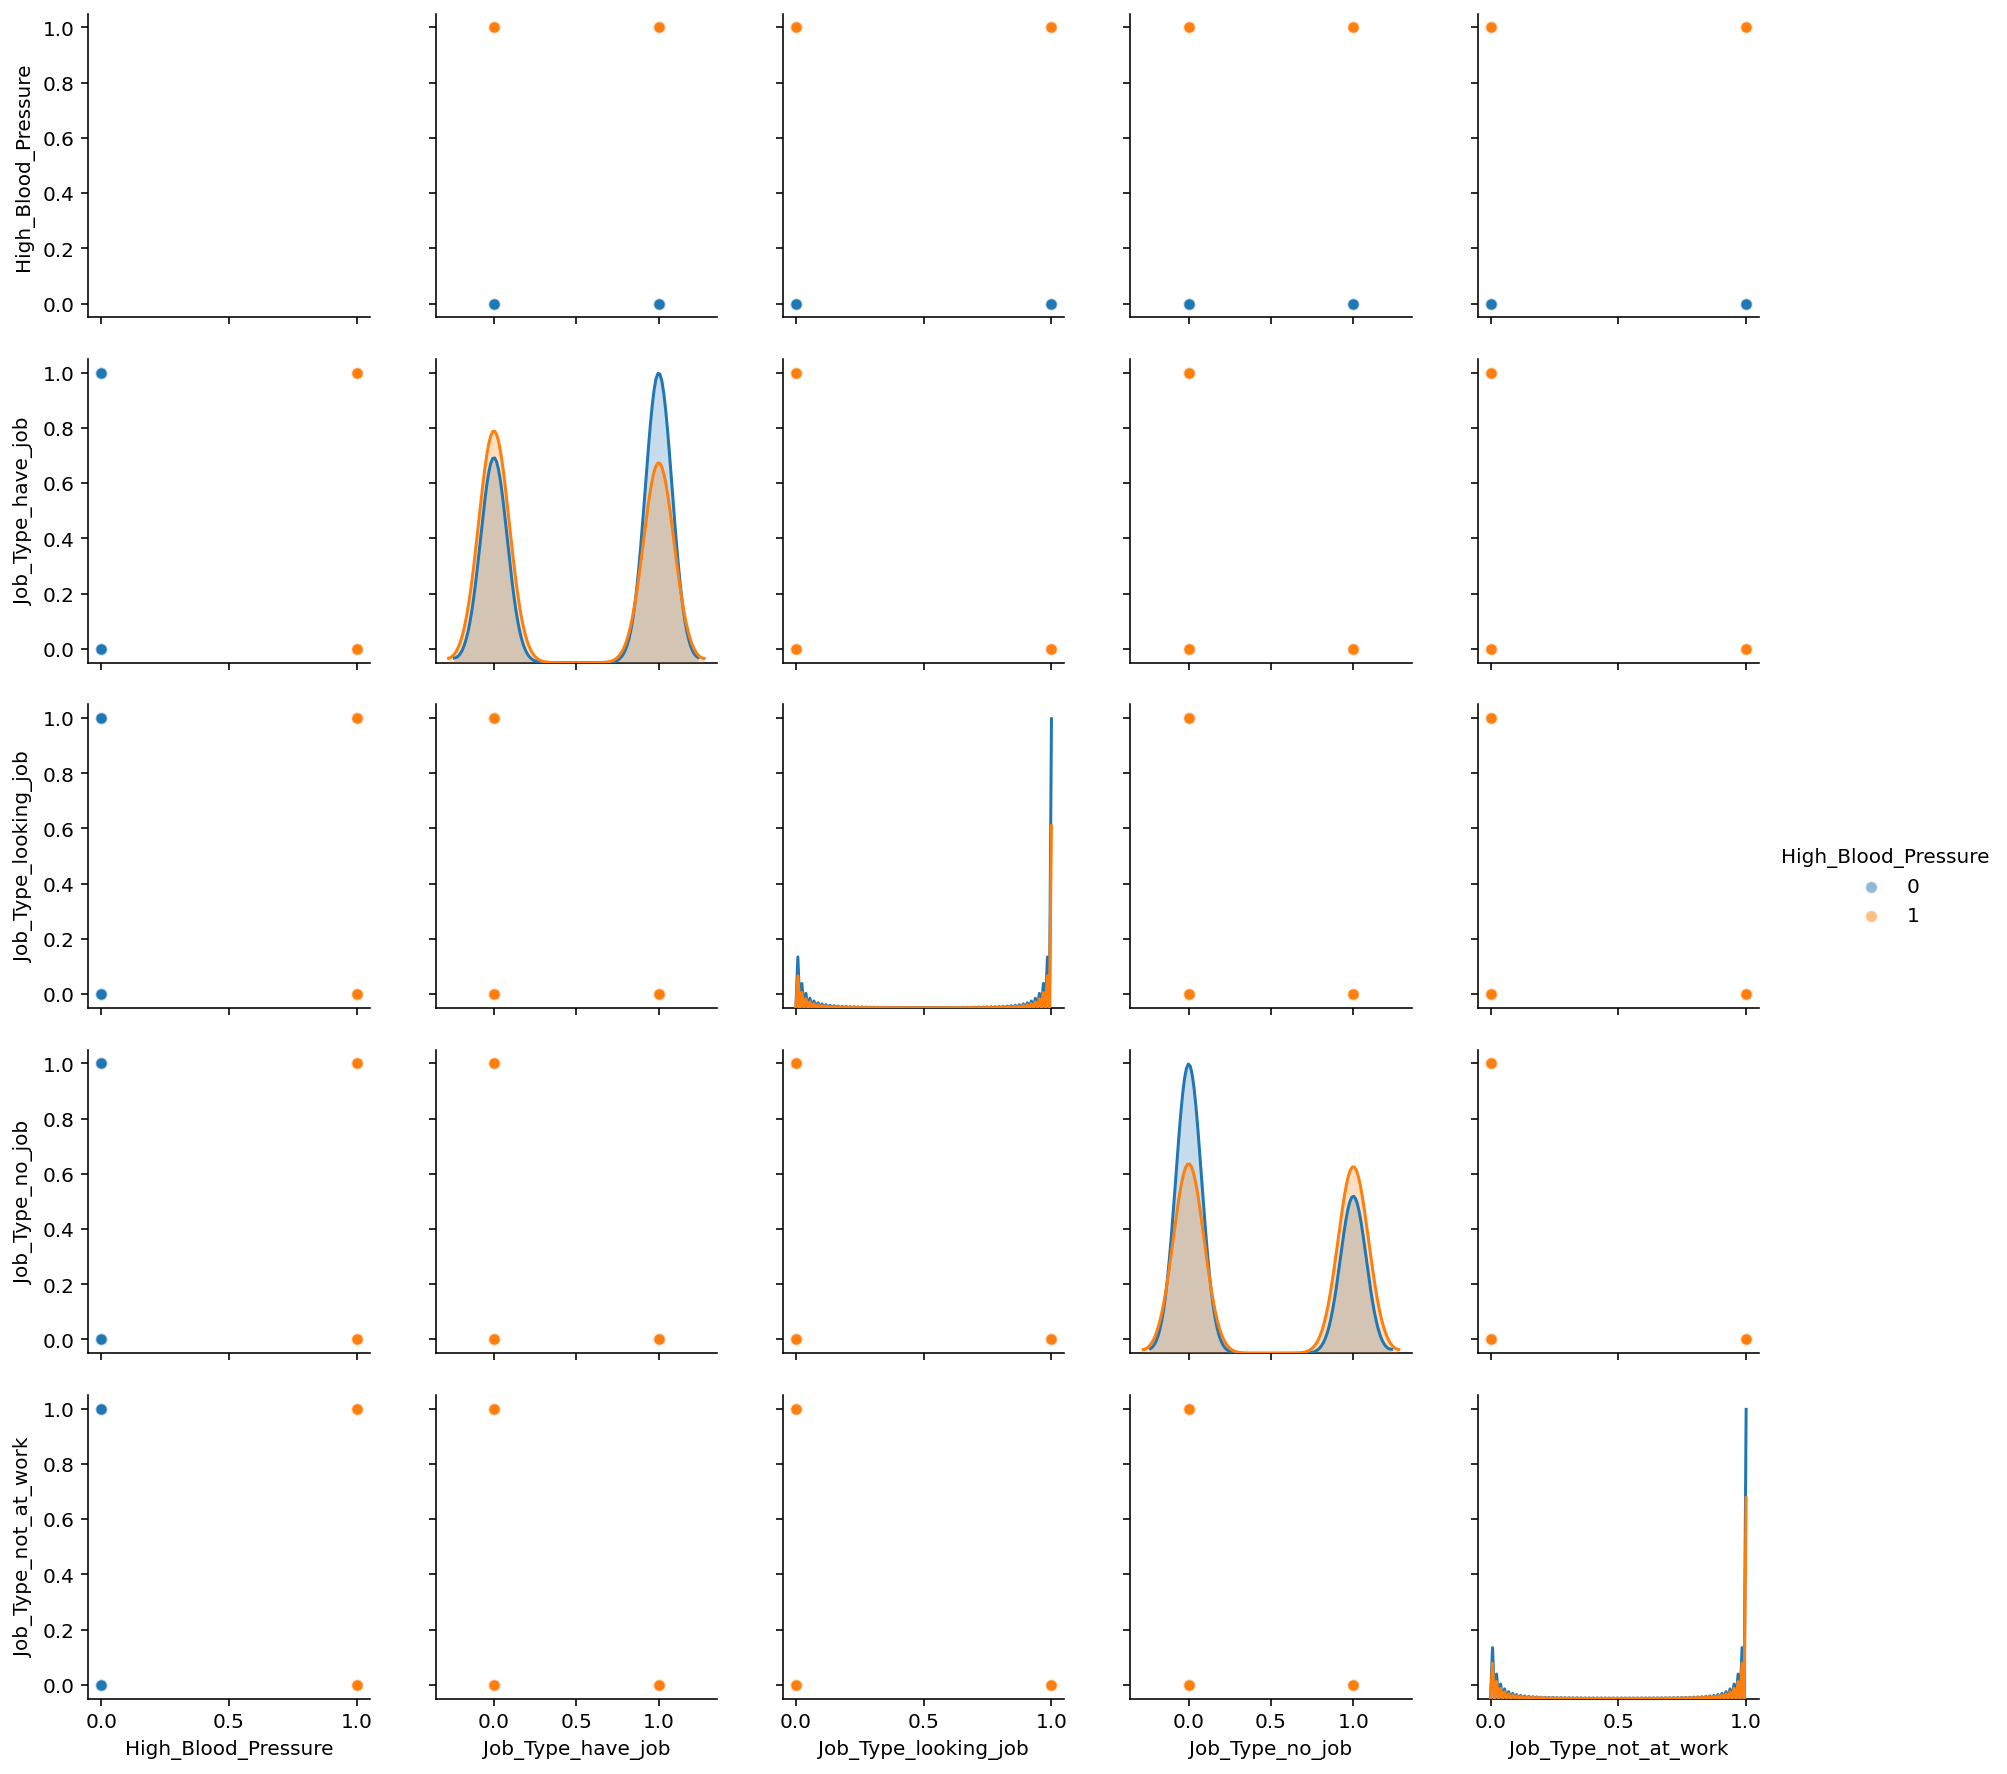

In [16]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Job_Type_have_job',
                           'Job_Type_looking_job',
                           'Job_Type_no_job','Job_Type_not_at_work'
                          ]],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Race - Black**: Looks like there may be a relationship between identifying as Black and having high blood pressure

-</br>
-</br>
## MODELING

-</br>
### Logistic Regression Model v1
Starting with model that has minimal features >

In [277]:
std_scale = StandardScaler()

#features we want to use in this model
v1_features = ['Age', 'Waist_Circum']

#create new X set of v1 features for training and test set
X_train_v1 = X_train[v1_features]
X_val_v1 = X_val[v1_features]
X_test_v1 = X_test[v1_features]

# scale all of the features for training and test set
X_train_scaled_v1 = std_scale.fit_transform(X_train_v1)
X_val_scaled_v1 = std_scale.fit_transform(X_val_v1)
X_test_scaled_v1 = std_scale.fit_transform(X_test_v1)

# create training model using scaled features
lm1 = LogisticRegression(solver='liblinear').fit(X_train_scaled_v1, y_train)

In [278]:
# create predicted values of lm1 model

y_pred_lm1 = lm1.predict(X_test_scaled_v1)

# create list of predicted probabilities for lm1 model

lm1_predict_prob = lm1.predict_proba(X_test_scaled_v1)

In [279]:
# validate score/accuracy for the lm1 model
print('SCORE for lm1 Model (Validation):')
lm1.score(X_val_scaled_v1, y_val)

SCORE for lm1 Model (Validation):


0.6772686832740213

In [280]:
# create simple confusion matrix

confusion_matrix(y_test, y_pred_lm1)

array([[2445,  476],
       [ 996,  579]])

In [281]:
print('SCORE for v1 Model:')
lm1.score(X_test_scaled_v1, y_test)

SCORE for v1 Model:


0.6725978647686833

In [282]:
# using the default threshold of 0.5

print("For lm1 model with threshold of 0.5 (default):")
print(f'''    Precision: {precision_score(y_test, y_pred_lm1)}, 
    Recall: {recall_score(y_test, y_test_pred_lm1)}''')

For lm1 model with threshold of 0.5 (default):
    Precision: 0.5488151658767773, 
    Recall: 0.37015873015873013


In [283]:
# using the new threshold of 0.3
y_pred_lm1_thres3 = (lm1.predict_proba(X_test_scaled_v1)[:,1] > 0.3)
print("For lm1 model with threshold of 0.3:")
print(f'''    Precision: {precision_score(y_test, y_pred_lm1_thres3)}, 
    Recall: {recall_score(y_test, y_pred_lm1_thres3)}''')

For lm1 model with threshold of 0.3:
    Precision: 0.4846061575369852, 
    Recall: 0.7695238095238095


In [284]:
# find coefficients

print('Coefficients for lm1 model:')
cofficients_lm1 = dict(zip(X_test_v1.columns, [x for nest in lm1.coef_ for x in nest]))
cofficients_lm1

Coefficients for lm1 model:


{'Age': 0.737839979537066, 'Waist_Circum': 0.30135218208025066}

In [285]:
# find intercept

print('Intercept for lm1 Model:')
print(lm1.intercept_)

Intercept for lm1 Model:
[-0.72278041]


In [286]:
print('Classification Report for lm1 model with 0.3 threshold:')
print(classification_report(y_test, y_pred_lm1_thres3))

Classification Report for lm1 model with 0.3 threshold:
              precision    recall  f1-score   support

           0       0.82      0.56      0.66      2921
           1       0.48      0.77      0.59      1575

    accuracy                           0.63      4496
   macro avg       0.65      0.66      0.63      4496
weighted avg       0.70      0.63      0.64      4496



-</br>
### Logistic Regression Model v2

Adding additional features to the Logistic Regression model >

In [287]:
std_scale = StandardScaler()

#features we want to use in this model (lm2)
v2_features = ['Age','Weight','Alcohol_Amt',
               'Race_Non_Hispanic_Black','Job_Type_have_job'
              ]

#create new X set of v2 features for training and test set
X_train_v2 = X_train[v2_features]
X_val_v2 = X_val[v2_features]
X_test_v2 = X_test[v2_features]

# scale all of the features for training and test set
X_train_scaled_v2 = std_scale.fit_transform(X_train_v2)
X_val_scaled_v2 = std_scale.fit_transform(X_val_v2)
X_test_scaled_v2 = std_scale.fit_transform(X_test_v2)

# create training model using scaled features
lm2 = LogisticRegression(solver='liblinear').fit(X_train_scaled_v2, y_train)


In [288]:
# validate score/accuracy for the lm2 model
print('SCORE for v2 Model (Validation):')
lm2.score(X_val_scaled_v2, y_val)

SCORE for v2 Model (Validation):


0.6790480427046264

In [289]:
# score/accuracy for the lm2 model
print('SCORE for v2 Model (Test):')
lm2.score(X_test_scaled_v2, y_test)

SCORE for v2 Model (Test):


0.6705960854092526

#### Takeaways of Accuracy Score:
- On test, high accuracy score than lm1 model and tried multiple features in this lm2 model to find that this feature combination performed the best.  

-</br>

Will look at other metrics to see how good this model really is compared to others >

In [290]:
# find coefficients for this lm2 model

print('COEFFICIENTS for lm2 model:')
cofficients_lm2 = dict(zip(X_test_v2.columns, [x for nest in lm2.coef_ for x in nest]))
pd.DataFrame.from_dict(cofficients_lm2, orient='index', columns=['lm2_coefs'])

COEFFICIENTS for lm2 model:


lm2_coefs
Age                       0.879311
Weight                    0.302253
Alcohol_Amt               0.149952
Race_Non_Hispanic_Black   0.167358
Job_Type_have_job         0.029518

In [291]:
print('INTERCEPT for lm2 Model:')
print(lm2.intercept_)

INTERCEPT for lm2 Model:
[-0.73816581]


In [292]:
# create predicted values of lm1 model

y_pred_lm2 = lm2.predict(X_test_scaled_v2)

In [293]:
# create simple confusion matrix

confusion_matrix(y_test, y_pred_lm2)

array([[2414,  507],
       [ 974,  601]])

In [294]:
# plot the confusion matrix

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_scaled_v2)[:, 1] >= threshold)
    bp_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(bp_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Safe BP', 'High BP'],
           yticklabels=['Safe BP', 'High BP']);
    plt.title('Confusion Matrix for High Blood Pressure Logistic Reg Model')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

For lm2 model, 0.5 threshold:


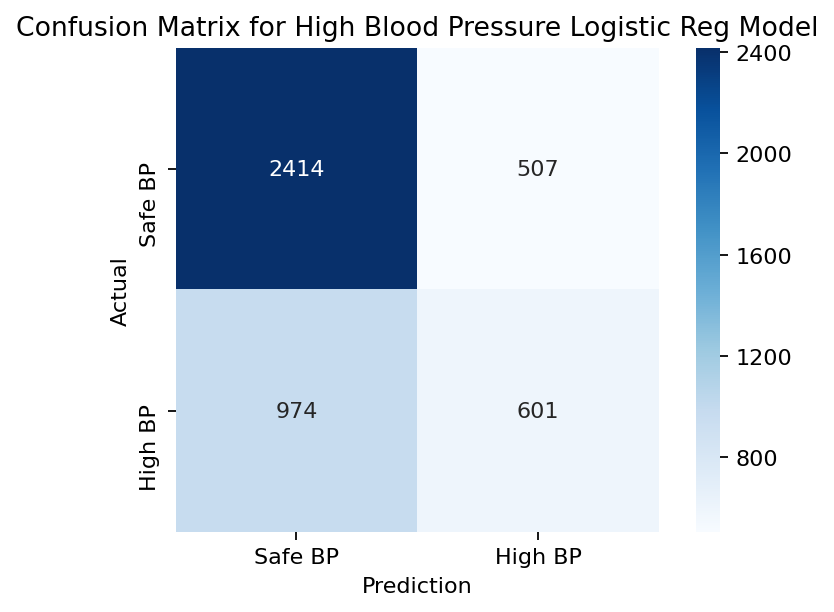

In [295]:
# version with default threshold of 0.5
print('For lm2 model, 0.5 threshold:')
make_confusion_matrix(lm2)

#### Takeaways of Confusion Matrix:
- Higher precision than recall with default threshold, but will want higher recall, as it will be more important to catch those that do have high blood pressure vs. asking others who actually don't have high blood pressure to come back in for testing (i.e. the False Positives)

FOR lm2 model, 0.3 threshold:


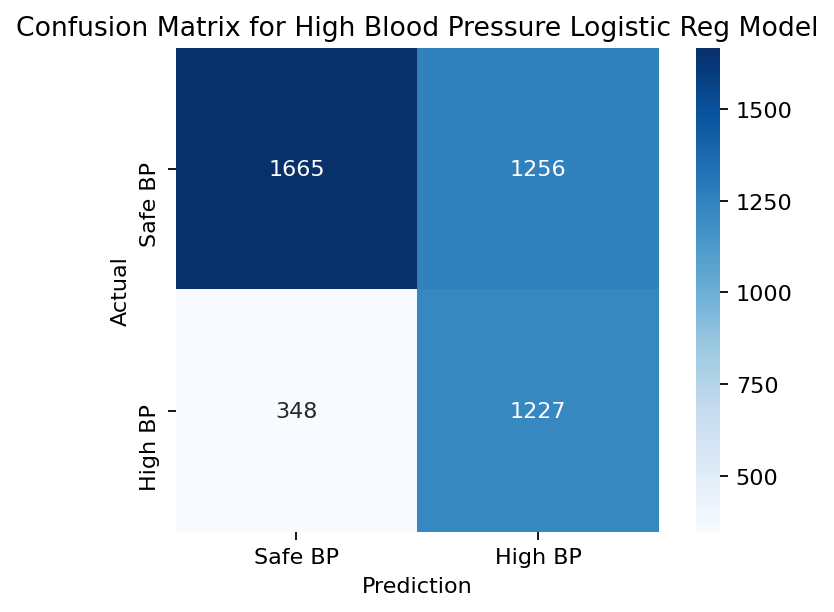

In [296]:
# version of confusion matrix with .3 threshold

print('FOR lm2 model, 0.3 threshold:')
make_confusion_matrix(lm2, threshold=0.3)

#### Takeaways of Confusion Matrix - Threshold tests:
- Tried playing with various thresholds and 0.3 is likely the direction we want to take for a threshold.  This means there are a very high number of people with False Positives, but lowers the False Negatives to a point where will capture many who do have high blood pressure

In [297]:
# create list of predicted probabilities for lm2 model

lm2_predict_prob = lm2.predict_proba(X_test_scaled_v2)

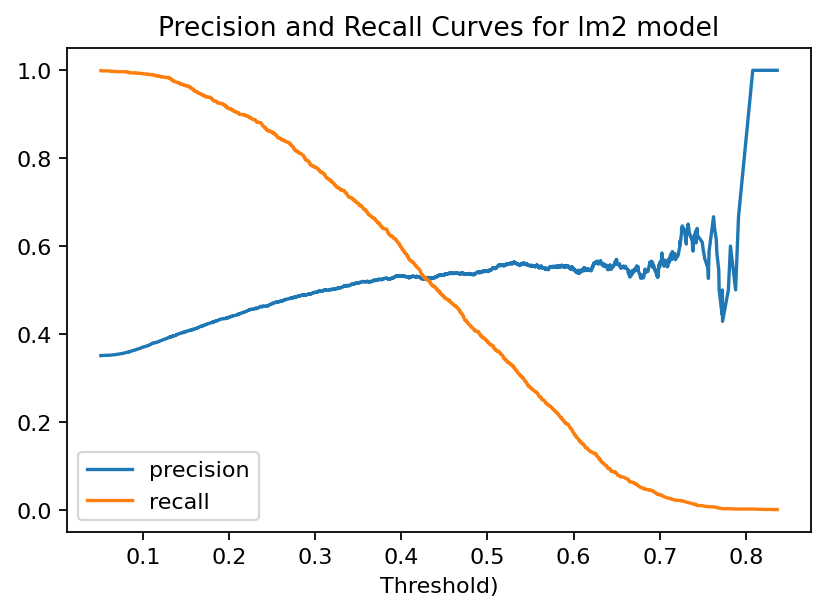

In [298]:
# Build graph of precision & recall curves along threshold to understand their relationship
#    and examine threshold options

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm2_predict_prob[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold)');
plt.title('Precision and Recall Curves for lm2 model');

In [299]:
# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr, tpr, thresholds = roc_curve(y_test, lm2_predict_prob[:,1])

ROC AUC score for lm2 model =  0.7201238975562837


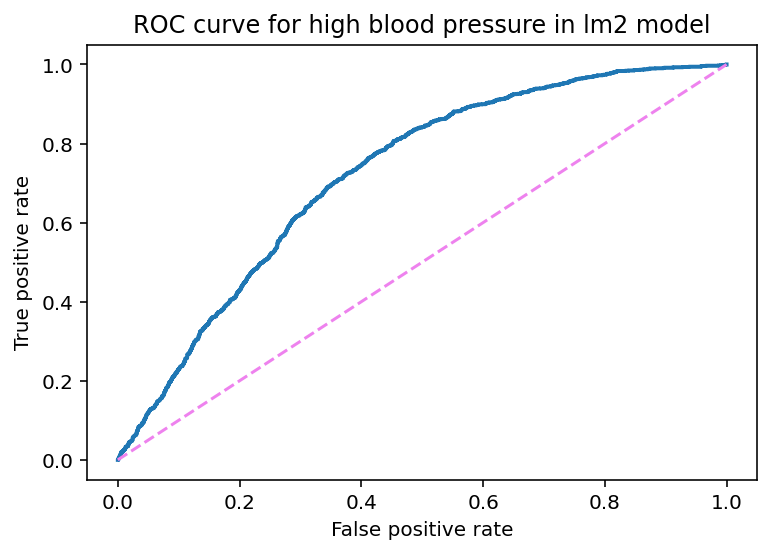

In [300]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in lm2 model');
print("ROC AUC score for lm2 model = ", roc_auc_score(y_test, lm2_predict_prob[:,1]))

-
#### Precision & Recall Scores
Looking at difference between default and .28 threshold identified above

In [301]:
# using the default threshold of 0.5

print("For lm2 model with threshold of 0.5 (default):")
print(f'''    Precision: {precision_score(y_test, y_pred_lm2)}, 
    Recall: {recall_score(y_test, y_pred_lm2)}''')

For lm2 model with threshold of 0.5 (default):
    Precision: 0.5424187725631769, 
    Recall: 0.3815873015873016


In [382]:
# using the new threshold of 0.23

y_pred_lm2_thres23 = (lm2.predict_proba(X_test_scaled_v2)[:,1] > 0.23)
print("For lm2 model with threshold of 0.23:")
print(f'''    Precision: {precision_score(y_test, y_pred_lm2_thres23)}, 
    Recall: {recall_score(y_test, y_pred_lm2_thres23)}''')

For lm2 model with threshold of 0.23:
    Precision: 0.45761047463175125, 
    Recall: 0.8876190476190476


-</br>
#### F1 Score
Looking at difference between default and .3 threshold identified above

In [303]:
print(f'F1 SCORE for lm2 model with 0.5 threshold: {f1_score(y_test, y_pred_lm2)}')

F1 SCORE for lm2 model with 0.5 threshold: 0.44800596347372346


In [383]:
print(f'F1 SCORE for lm2 model with 0.23 threshold: {f1_score(y_test, y_pred_lm2_thres23)}')

F1 SCORE for lm2 model with 0.23 threshold: 0.6038876889848812


-
#### Full Classification Report

In [384]:
print('Classification Report for lm2 model with 0.3 threshold:')
print(classification_report(y_test, y_pred_lm2_thres23))

Classification Report for lm2 model with 0.3 threshold:
              precision    recall  f1-score   support

           0       0.88      0.43      0.58      2921
           1       0.46      0.89      0.60      1575

    accuracy                           0.59      4496
   macro avg       0.67      0.66      0.59      4496
weighted avg       0.73      0.59      0.59      4496



-</br>
### Logistic Regression With Oversampling Model
Because we have an imbalanced split of our target (approx 35% positive and 65% negative) will try to see if correcting for imbalance will improve model.  Will try oversampling for the 'minority class' (those with high blood pressure) >

In [310]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_over, y_train_over = ros.fit_sample(X_train_scaled_v2,y_train)
X_val_over, y_val_over = ros.fit_sample(X_val_scaled_v2,y_val)

In [311]:
# Verify samples are now in balance with target:
    
Counter(y_scaled_resampled)

Counter({0: 8761, 1: 8761})

In [312]:
clf1 = LogisticRegression(solver='liblinear')
clf1.fit(X_train_over, y_train_over)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

FOR clf1 model, 0.4 threshold:


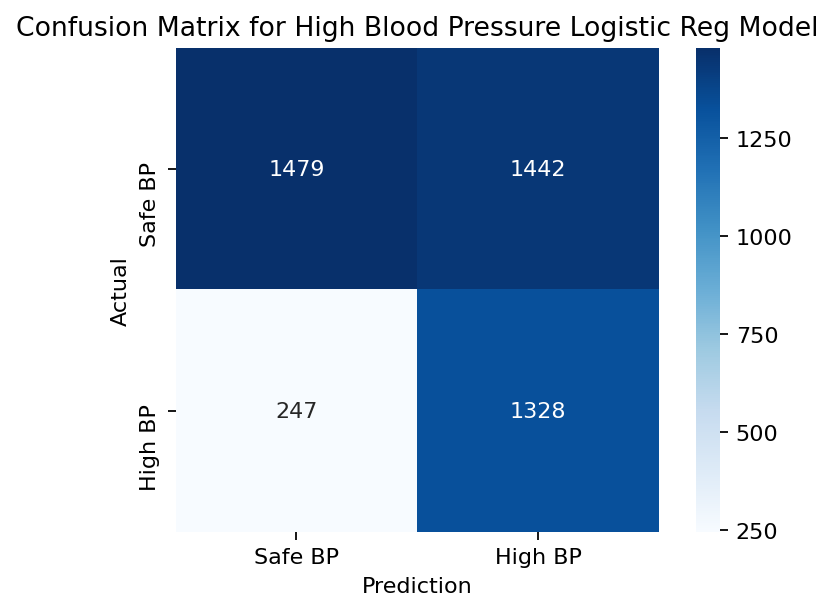

In [316]:
print('FOR clf1 model, 0.4 threshold:')
make_confusion_matrix(clf1, threshold=0.4)

#### TAKEAWAYS
- Can set a higher threshold now and have less false negatives without false positives getting too far out of control.  Let's look more closely at other metrics to compare to lm2 >

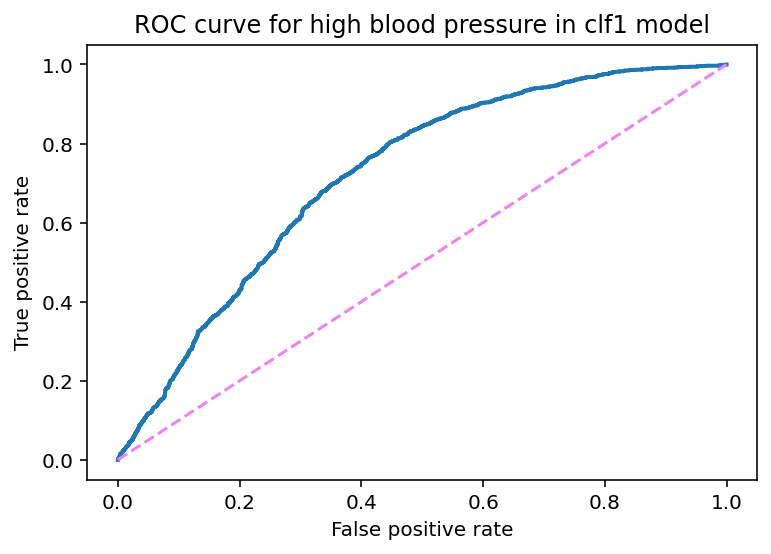

In [317]:
# plot ROC curve

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_pred_prob_clf1[:,1])

plt.plot(fpr_clf, tpr_clf,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in clf1 model');

In [395]:
# create predicted values of lm1 model

y_pred_clf1 = clf1.predict(X_test_scaled_v2)


# create predicted values of clf1 model

y_pred_prob_clf1 = (clf1.predict_proba(X_test_scaled_v2))


# create predicted probabilities of clf1 model at 0.4 thresholds

y_pred_clf1_thres33 = (clf1.predict_proba(X_test_scaled_v2)[:,1] > 0.33)

In [396]:
# score/accuracy for the clf1 model

print(f'ACCURACY SCORE for clf1 model (VALIDATION):{clf1.score(X_val_scaled_v2, y_val)}')

print(f'ACCURACY SCORE for clf1 model (TEST):{clf1.score(X_test_scaled_v2, y_test)}')

ACCURACY SCORE for clf1 model (VALIDATION):0.6685943060498221
ACCURACY SCORE for clf1 model (TEST):0.6641459074733096


In [397]:
print("For clf1 model at default threshold (0.5):")
print(f'''    Precision: {precision_score(y_test, y_pred_clf1)}, 
    Recall: {recall_score(y_test, y_pred_clf1)}''')

For clf1 model at default threshold (0.5):
    Precision: 0.5152510558423276, 
    Recall: 0.6971428571428572


In [401]:

print("clf1 model at threshold of 0.33:")
print(f'''    Precision: {precision_score(y_test, y_pred_clf1_thres33)}, 
    Recall: {recall_score(y_test, y_pred_clf1_thres33)}''')

clf1 model at threshold of 0.33:
    Precision: 0.4469221105527638, 
    Recall: 0.9034920634920635


#### TAKEAWAYS
- Precision and Recall are both higher, so as of now, this model (clf1) is leading

Let's now get other metrics to look at >

In [402]:

print(f'F1 SCORE for clf1 model with 0.33 threshold: {f1_score(y_test, y_pred_clf1_thres33)}')

F1 SCORE for clf1 model with 0.33 threshold: 0.5980247951250263


In [323]:
print("ROC AUC score for clf1 model = ", roc_auc_score(y_test, y_pred_clf1))

ROC AUC score for clf1 model =  0.6717484227515038


In [403]:
print("ROC AUC score for clf1 model with .33 threshold = ", roc_auc_score(y_test, y_pred_clf1_thres3))

ROC AUC score for clf1 model with .33 threshold =  0.6373085972949034


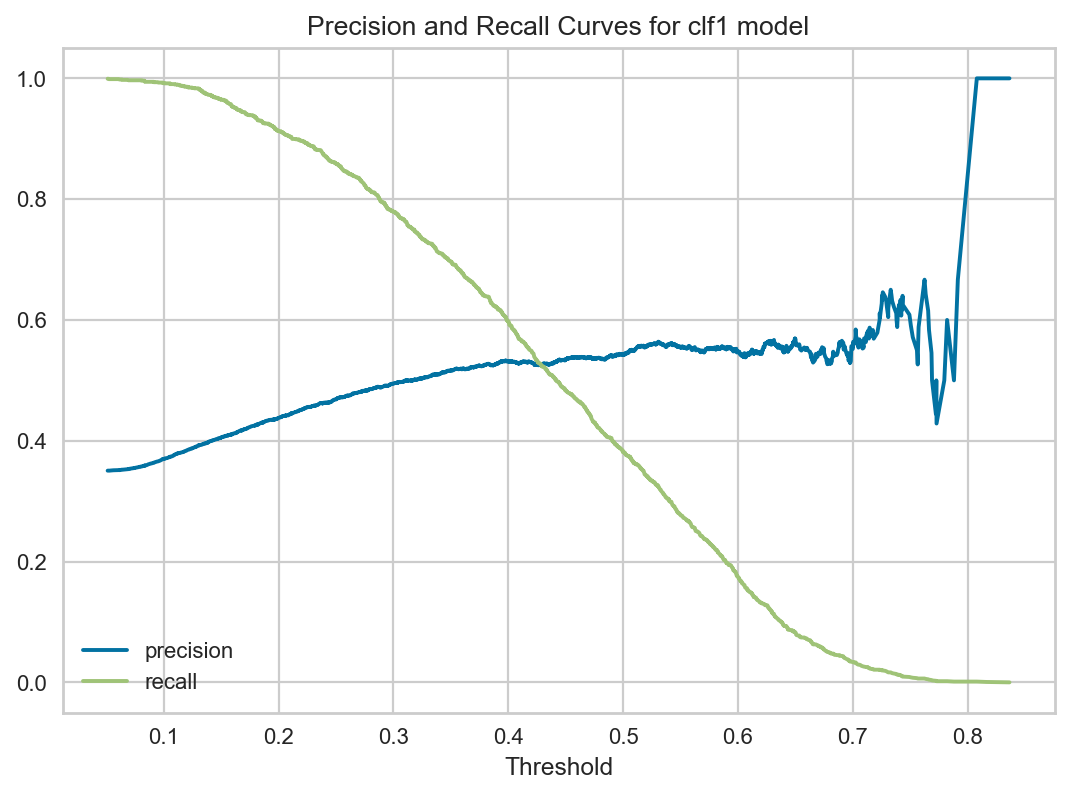

In [392]:
# Build graph of precision & recall curves along threshold to understand their relationship
#    and examine threshold options

precision_curve_clf1, recall_curve_clf1, threshold_curve_clf1 = precision_recall_curve(
    y_test, clf1_predict_prob[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves for clf1 model');


In [329]:
# find coefficients for this clf1 model

print('SCALED COEFFICIENTS for clf1 Model:')
cofficients_clf1 = dict(zip(X_test_v2.columns, [x for nest in clf1.coef_ for x in nest]))
cofficients_clf1_df = pd.DataFrame.from_dict(cofficients_clf1, orient='index', columns=['clf1_coefs'])
cofficients_clf1_df

SCALED COEFFICIENTS for clf1 Model:


clf1_coefs
Age                        0.896423
Weight                     0.339306
Alcohol_Amt                0.139621
Race_Non_Hispanic_Black    0.153225
Job_Type_have_job          0.023783

In [337]:
list(cofficients_clf1_df.index)

['Age',
 'Weight',
 'Alcohol_Amt',
 'Race_Non_Hispanic_Black',
 'Job_Type_have_job']

In [98]:
print('INTERCEPT for clf1 Model:')
print(clf1.intercept_)

INTERCEPT for clf1 Model:
[-0.12977284]


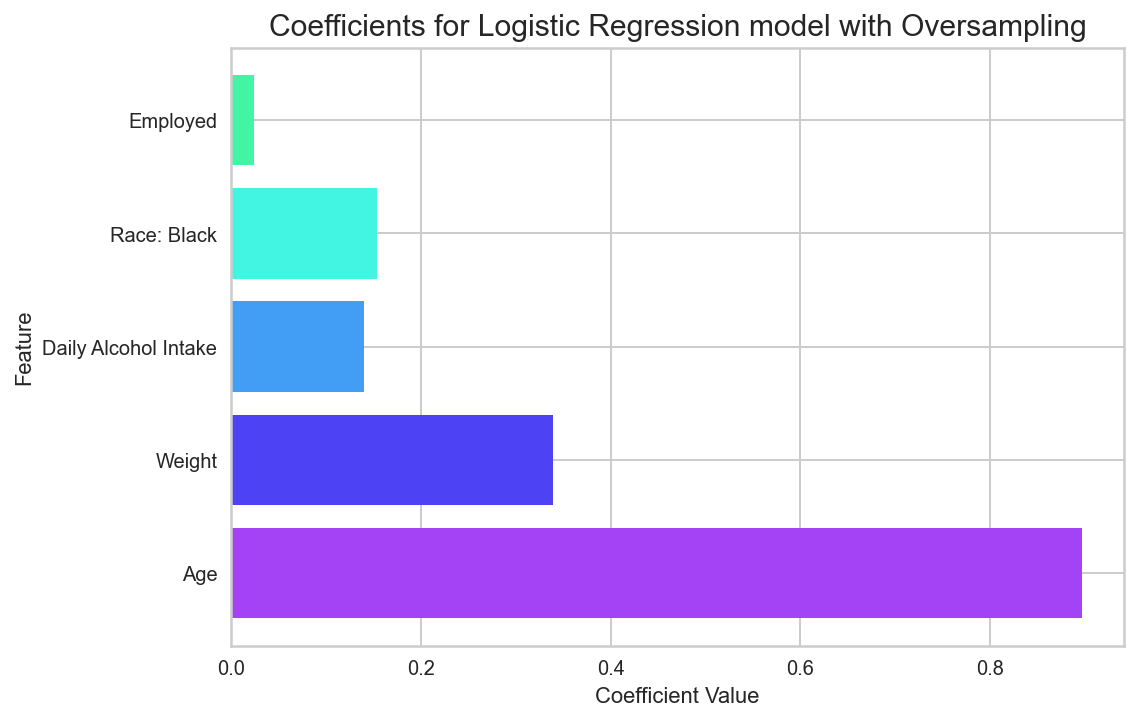

In [352]:
# plot coefficients for clf1 model

x = ['Age','Weight','Daily Alcohol Intake','Race: Black', 'Employed']
coefs = list(cofficients_clf1_df.clf1_coefs)

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, coefs, color=['#a442f5','#4e42f5','#429ef5','#42f5e3', '#42f5a4'])
plt.ylabel("Feature")
plt.xlabel("Coefficient Value")
plt.title("Coefficients for Logistic Regression model with Oversampling", size = 15)

plt.yticks(x_pos, x)

plt.show()

-
### Decision Tree Model
For sake of always trying all options to find optimal performance of models, will now try decision tree models to predict high blood pressure


First, using v2 of narrowed features (5 total) used in lm2 and clf1 above >

In [359]:
dt1 = DecisionTreeClassifier(max_depth=6)

dt1.fit(X_train_v2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [360]:
y_predict_dt1 = dt1.predict(X_test_v2)
print("For dt1 model:")
print(f'''    Precision: {precision_score(y_test, y_predict_dt1)}, 
    Recall: {recall_score(y_test, y_predict_dt1)}''')

For dt1 model:
    Precision: 0.5597964376590331, 
    Recall: 0.41904761904761906


In [361]:
# using the new threshold of 0.23
y_predict_dt_thres23 = (dt1.predict_proba(X_test_v2)[:,1] > 0.23)
print("Model dt1 with 0.23 threshold:")
print(f'''   Precision: {precision_score(y_test, y_predict_dt_thres23)}, 
   Recall: {recall_score(y_test, y_predict)}''')

Model dt1 with 0.23 threshold:
   Precision: 0.45273950656840756, 
   Recall: 0.38476190476190475


#### Takeaways of dt1 model - Threshold tests:
- Recall not performing any better (much worse in fact) than with clf1 model, so not standing out as option to persue

-
### Decision Tree Model w/All Features
Opening model to try to work with all original features

In [ ]:
dt2 = DecisionTreeClassifier(max_depth=54)

dt2.fit(X_train, y_train)

In [ ]:
print(f'ACCURACY SCORE for dt2 model:{dt2.score(X_test, y_test)}')

In [ ]:
# using default threshold
print("For dt2 model with default threshold:")
print(f'''Precision: {precision_score(y_test, y_predict_dt2)}, 
Recall: {recall_score(y_test, y_predict_dt2)}''')

In [ ]:
# using the new threshold of 0.23
y_predict_dt2 = (dt2.predict_proba(X_test)[:,1] > 0.23)
print("Model dt2 with 0.23 threshold:")
print(f'''   Precision: {precision_score(y_test, y_predict_dt2)}, 
   Recall: {recall_score(y_test, y_predict)}''')

The 0.23 threshold was still the best that could be done to get recall up near where our clf1 model was performing without extreme sacrifice to precision -- but both still less than clf1 model, so isn't standing out as better option

In [ ]:
y_predict_dt2 = (dt2.predict_proba(X_test)[:, 1] > 0.23)
print(f'F1 SCORE for dt2 model with 0.34 threshold: {f1_score(y_test, y_predict_dt2)}')

#### TAKEAWAYS FOR 'ALL FEATURE' DECISION TREE
- Can get slightly better scores if using all features, but had to set max_depth to 54 to get recall higher than precision -- and still both numbers are less than logistic regression balanced model (clf1), so doesn't seem like good approach

*Now to look at the Random Forest model to see if can improve model >*

-
### Random Forest Model
Again, continue to try model options to find optimal performance >

First, again using v2 of narrowed features (5 total) used in lm2 and clf1 above

In [362]:
rf1 = RandomForestClassifier(n_estimators=100)

rf1.fit(X_train_v2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [366]:
rf1.feature_importances_

array([0.31413027, 0.56570659, 0.0906338 , 0.01285437, 0.01667497])

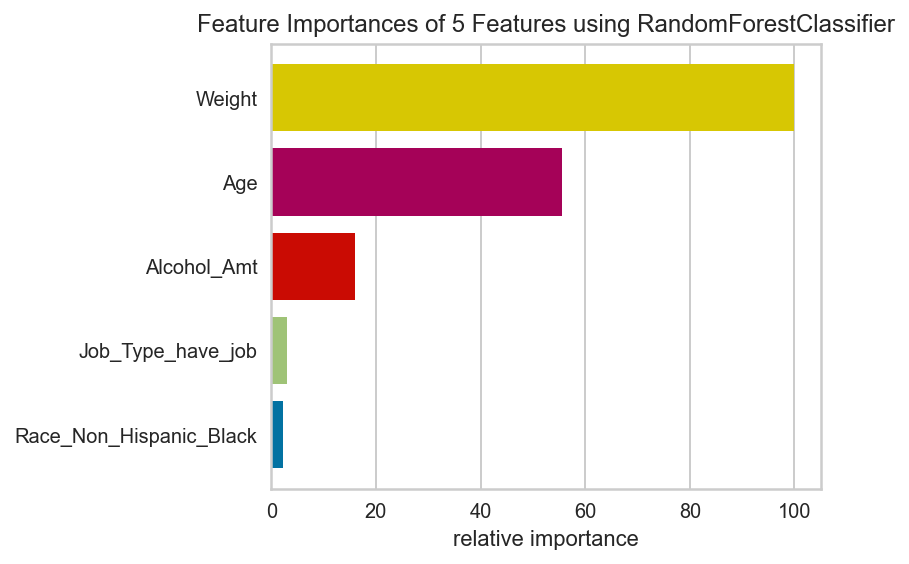

In [415]:
# plot coefficients for model


model = RandomForestClassifier(n_estimators=100)
viz = FeatureImportances(rf1)
viz.fit(X_train_v2, y_train)
viz.show()

In [368]:
y_predict_rf1 = rf1.predict(X_test_v2)
print("For rf1 model:")
print(f'''   Precision: {precision_score(y_test, y_predict_rf1)}, 
   Recall: {recall_score(y_test, y_predict_rf1)}''')

For rf1 model:
   Precision: 0.4805290227773696, 
   Recall: 0.41523809523809524


In [ ]:
# get predicted probabilities for rf2
rf2_predict_prob = (rf1.predict_proba(X_test_v2)[:,1])

# get predicted probabilities for rf2 model at new threshold of 0.2
y_predict_rf1_thres2 = (rf1.predict_proba(X_test_v2)[:,1] > 0.2)

In [409]:
# using the new threshold of 0.2
print("Model dt2 with 0.2 threshold:")
print(f'''   Precision: {precision_score(y_test, y_predict_rf1_thres2)}, 
   Recall: {recall_score(y_test, y_predict_rf1_thres2)}''')

Model dt2 with 0.2 threshold:
   Precision: 0.4433586681143684, 
   Recall: 0.7777777777777778


#### TAKEAWAYS for rf1 model
- Precision and Recall are both lower than clf1 model.  Even when working with thresholds, could not get numbers to perform better than the clf1 model

Will again try opening all features up to see if that makes any difference in performance >

-
### Random Forest Model w/All Features
Opening model to try to work with all original features

In [372]:
rf2 = RandomForestClassifier(n_estimators=100)

rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [373]:
y_predict_rf2 = rf2.predict(X_test)
print("For rf2 model:")
print(f'''    Precision: {precision_score(y_test, y_predict_rf2)}, 
     Recall: {recall_score(y_test, y_predict_rf2)}''')

For rf2 model:
    Precision: 0.5513761467889908, 
     Recall: 0.3815873015873016


In [410]:
# using the new threshold of 0.24
y_predict_rf2_thres24 = (rf2.predict_proba(X_test)[:,1] > 0.24)
print("Model rf2 with 0.24 threshold:")
print(f'''   Precision: {precision_score(y_test, y_predict_rf2_thres24)}, 
   Recall: {recall_score(y_test, y_predict_rf2_thres24)}''')

Model rf2 with 0.24 threshold:
   Precision: 0.44884169884169883, 
   Recall: 0.8857142857142857


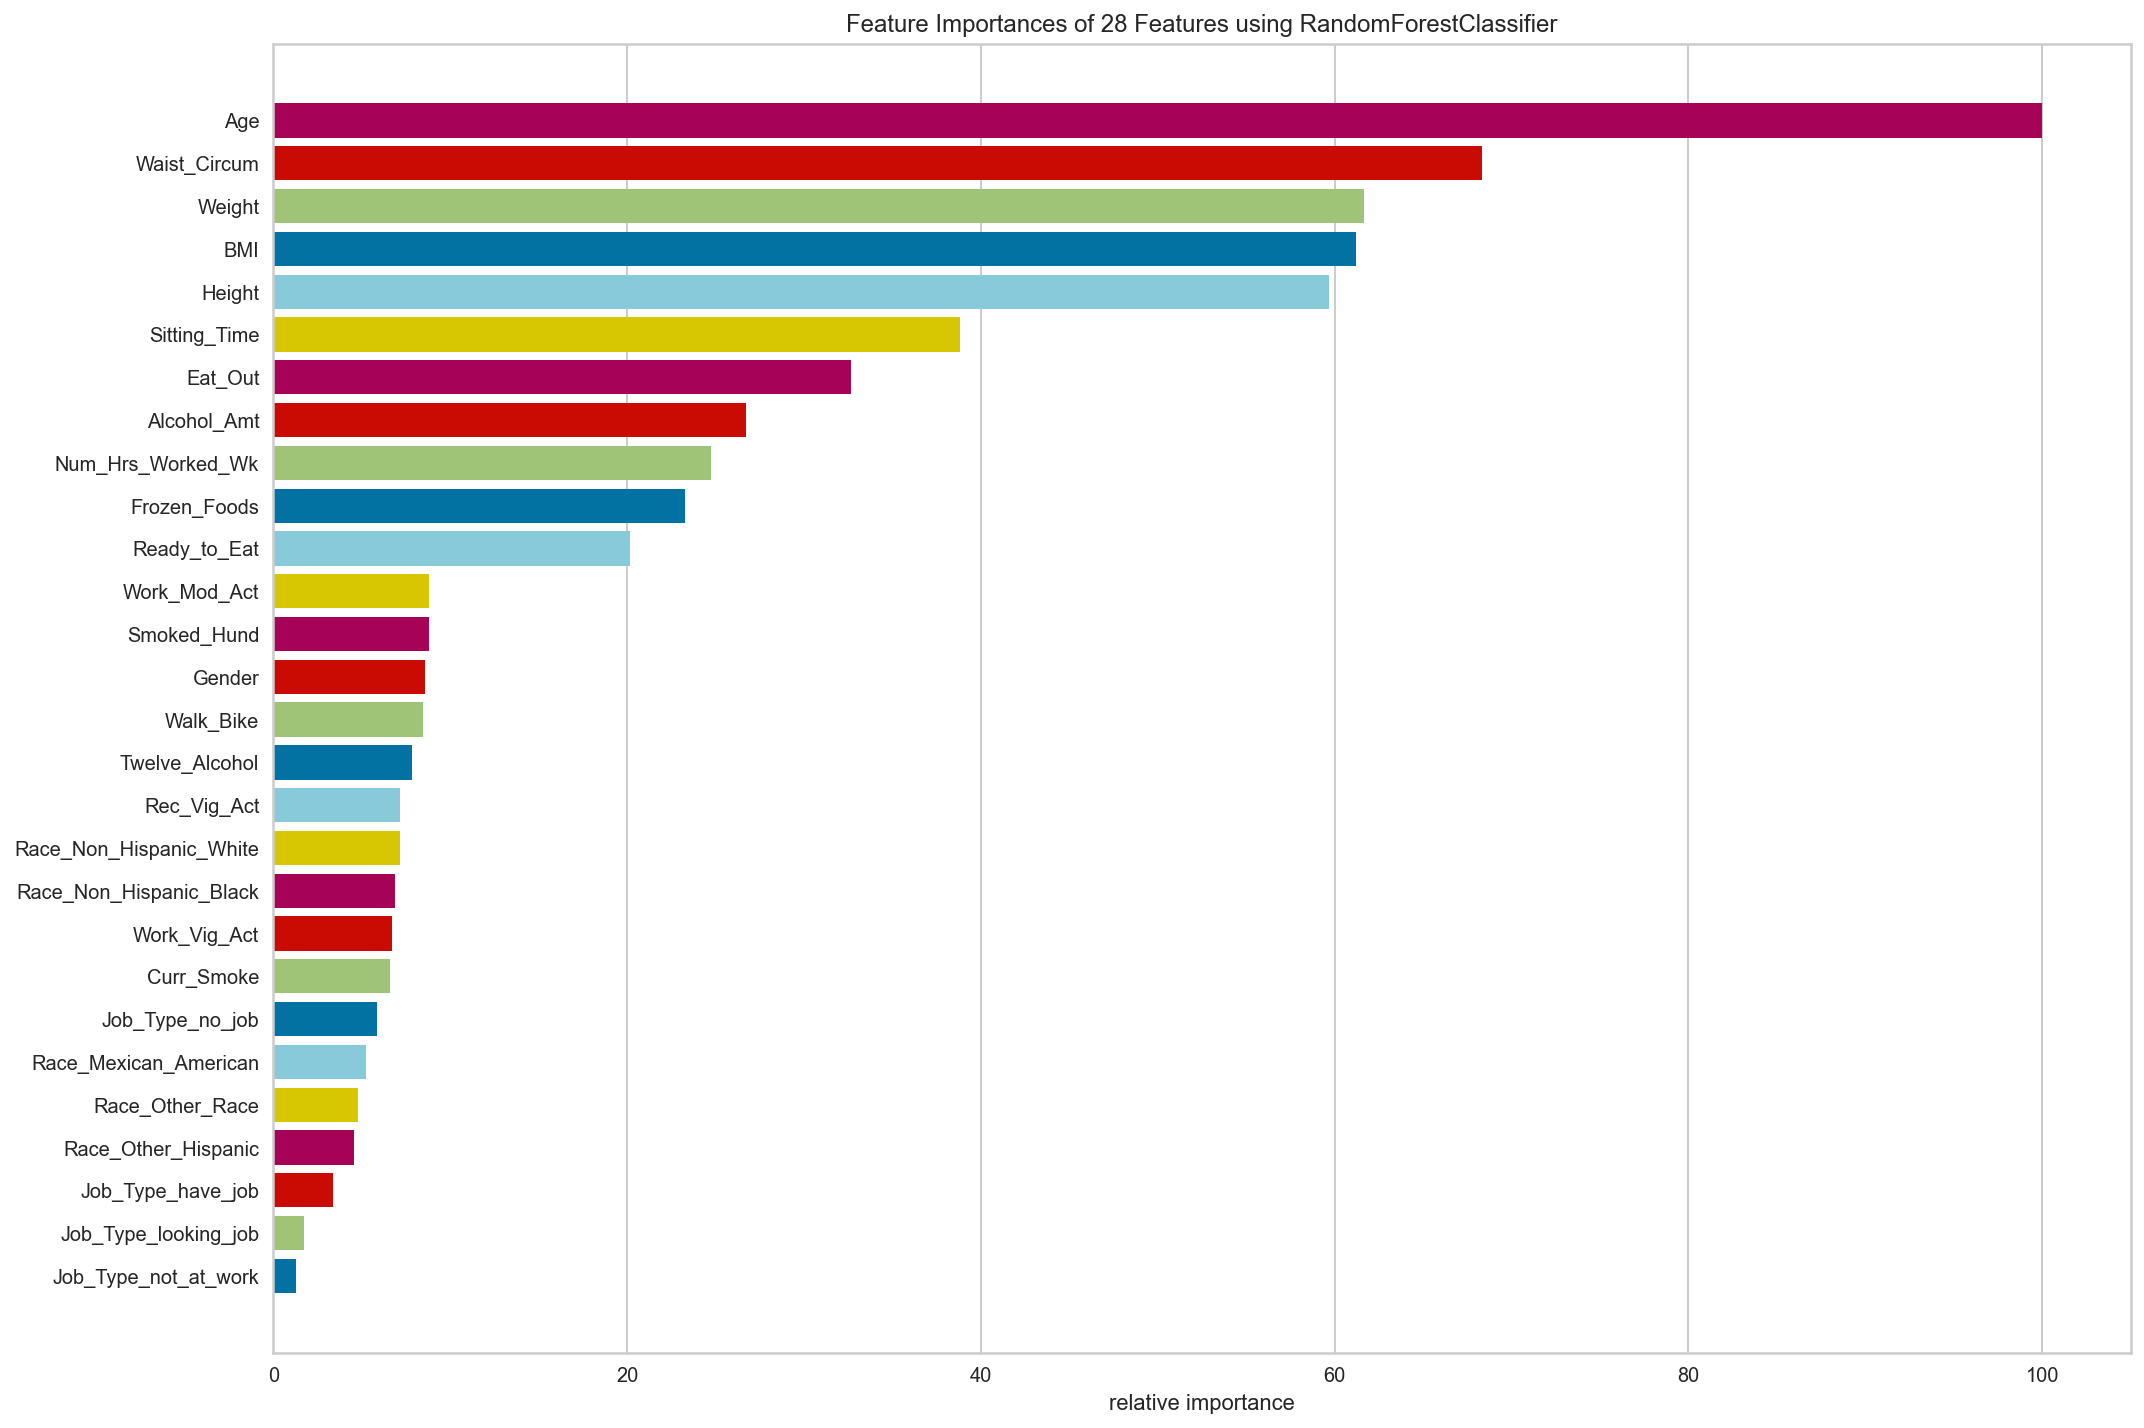

In [427]:
from yellowbrick.features import RadViz

# Import the visualizer
from yellowbrick.features import RadViz

# Instantiate the visualizer using the ``size`` param
visualizer = RadViz(
    classes='something', features=X_train.columns, size=(1080, 720)
)

model = RandomForestClassifier(n_estimators=100)
viz = FeatureImportances(rf2)
viz.fit(X_train, y_train)
viz.show();

#### TAKEAWAYS FOR 'ALL FEATURE' RANDOM FOREST
- Can get very slightly better precision and recall score with this model over clf1.  May still want to clf1 for simplicity's sake (e.g. make model easier to read and use by doctors, nurses, etc.), but should dig deeper into how complex this model is to make that call

-</br>
-</br>
### COMPARISON OF MODELS

First, reminder of names for each model:
- lm1 = Logistic Regression w/2 features & 0.3 threshold
- lm2 = Logistic Regression w/5 features & 0.23 threshold
- clf1 = Oversampled Logistic Regression w/5 features & 0.33 threshold
- dt2 = Decision Tree w/all 28 features
- rf2 = Random Forest w/all 28 features & 0.24 threshold

Now a summary of key metrics for all models considered >

#### Recall (main target metric)

In [411]:
print(f'lm1: {recall_score(y_test, y_pred_lm1_thres3)}')
print(f'lm2: {recall_score(y_test, y_pred_lm2_thres23)}')
print(f'clf1: {recall_score(y_test, y_pred_clf1_thres33)}')
print(f'rf2: {recall_score(y_test, y_predict_rf2_thres24)}')

lm1: 0.7695238095238095
lm2: 0.8876190476190476
clf1: 0.9034920634920635
rf2: 0.8857142857142857


#### Accuracy

-
#### Precision

In [412]:
print(f'lm1: {precision_score(y_test, y_pred_lm1_thres3)}')
print(f'lm2: {precision_score(y_test, y_pred_lm2_thres23)}')
print(f'clf1: {precision_score(y_test, y_pred_clf1_thres33)}')
# print(f'dt2: {precision_score(y_test, y_pred_lm2_thres3)}')
print(f'rf2: {precision_score(y_test, y_predict_rf2_thres24)}')

lm1: 0.4846061575369852
lm2: 0.45761047463175125
clf1: 0.4469221105527638
rf2: 0.44884169884169883


-
#### F1

In [413]:
print(f'lm1: {f1_score(y_test, y_pred_lm1_thres3)}')
print(f'lm2: {f1_score(y_test, y_pred_lm2_thres23)}')
print(f'clf1: {f1_score(y_test, y_pred_clf1_thres33)}')
print(f'rf2: {f1_score(y_test, y_predict_rf2_thres24)}')

lm1: 0.5947006869479882
lm2: 0.6038876889848812
clf1: 0.5980247951250263
rf2: 0.5957719410634209


-
#### F1 BETA

-
#### ROC AUC

In [408]:
print("lm1 model = ", roc_auc_score(y_test, lm1_predict_prob[:,1]))
print("lm2 model = ", roc_auc_score(y_test, lm2_predict_prob[:,1]))
print("clf1 model = ", roc_auc_score(y_test, clf1_predict_prob[:,1]))
print("rf2 model = ", roc_auc_score(y_test, rf2_predict_prob[:,1]))

lm1 model =  0.713973362025399
lm2 model =  0.7201238975562837
clf1 model =  0.7205575390032768


NameError: name 'rf2_predict_prob' is not defined